<a href="https://colab.research.google.com/github/jobellet/Dynamics-of-Visual-Representations-in-a-Macaque-Ventrolateral-Prefrontal-Cortex/blob/main/Controlling_evoked_eye_movements.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

-----------------------------------------------------------------------------
# Controlling evoked eye movements
-----------------------------------------------------------------------------
- Analysis of ocular signals in response to image content

- Reproduce all analysis of the paper with subset of trial not containing evoked eye movements confound
-----------------------------------------------------------------------------
## Private key
For the notebook to download the data from the Figshare repository prior to acceptance of the manuscript you need to insert the private link token mentioned in the "Code availability" section of the manuscript.

In [ ]:
private_link = input('Enter the private link token:')

# Download files

In [2]:
import os, sys, warnings
import numpy as np
import pandas as pd
import jax, jax.numpy as jnp
import matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm
from scipy.stats import rankdata

warnings.filterwarnings("ignore", category=FutureWarning)

# --------- Repo path (same logic as your other scripts)
IN_COLAB = False
IN_KAGGLE = False
try:
    if 'google.colab' in str(get_ipython()):
        IN_COLAB = True
except NameError:
    pass
if not IN_COLAB:
    if os.environ.get('KAGGLE_KERNEL_RUN_TYPE', 'Localhost') == 'Interactive':
        IN_KAGGLE = True

if IN_COLAB:
    path_to_repo = '/content/Dynamics-of-Visual-Representations-in-a-Macaque-Ventrolateral-Prefrontal-Cortex'
elif IN_KAGGLE:
    path_to_repo = '/kaggle/working/Dynamics-of-Visual-Representations-in-a-Macaque-Ventrolateral-Prefrontal-Cortex'
else:
    path_to_repo = 'Dynamics-of-Visual-Representations-in-a-Macaque-Ventrolateral-Prefrontal-Cortex/'

if not os.path.exists(path_to_repo):
    !git clone https://github.com/jobellet/Dynamics-of-Visual-Representations-in-a-Macaque-Ventrolateral-Prefrontal-Cortex.git
sys.path.append(path_to_repo)

from utils.extract_and_download_data import download_files

# --------- Files
files_to_download = [
    'Mean_eye_position_even_sessions.npy',
    'Mean_eye_position_odd_sessions.npy',
    'Mean_pupil_size_even_sessions.npy',
    'Mean_pupil_size_odd_sessions.npy',
    'Mean_eye_position_even_sessions_ms_free.npy',
    'Mean_eye_position_odd_sessions_ms_free.npy',
    'Mean_pupil_size_even_sessions_ms_free.npy',
    'Mean_pupil_size_odd_sessions_ms_free.npy',
    'df_saccades_odd.pkl',
    'df_saccades_even.pkl',
    'Spike_count_even_sessions_ms_free.npy',
    'Spike_count_odd_sessions_ms_free.npy',
    'valid_mask.npy',
    'valid_mask_ms_free.npy',
    'aggregated_eye_pos.npy',
    'saccade_data.pkl',
    'hvm_public_extended_meta.csv',
    'deepNetFeatures.zip',
    'mean_predprob_per_trial_lowpass.npy',
    'mean_pos_error_per_trial.npy',
    "deepNetFeatures_landscape.zip",
    'aggregated_eye_pos'
]
download_files(path_to_repo, files_to_download, private_link=private_link)

Cloning into 'Dynamics-of-Visual-Representations-in-a-Macaque-Ventrolateral-Prefrontal-Cortex'...
remote: Enumerating objects: 158, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (155/155), done.
remote: Total 158 (delta 80), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (158/158), 5.21 MiB | 8.49 MiB/s, done.
Resolving deltas: 100% (80/80), done.
Successfully downloaded downloads/hvm_public_extended_meta.csv.
Successfully downloaded downloads/deepNetFeatures_landscape.zip.
Successfully downloaded downloads/deepNetFeatures.zip.
Successfully downloaded downloads/mean_pos_error_per_trial.npy.
Successfully downloaded downloads/mean_predprob_per_trial_lowpass.npy.
Successfully downloaded downloads/df_saccades_odd.pkl.
Successfully downloaded downloads/Mean_pupil_size_odd_sessions.npy.
Successfully downloaded downloads/Mean_pupil_size_odd_sessions_ms_free.npy.
Successfully downloaded downloads/df_saccades_even.pkl.
Successfully d

# Consistency of eye signals

Saved: Figures/eye_pupil_microsaccade_zscore_timecourse.pdf
Eye:
  sign -, p=0.0140, mass=21.10, bins 16-19 → 165.0–195.0 ms
Pupil: no significant clusters.
Microsaccade:
  sign +, p=0.0010, mass=14.34, bins 16-17 → 165.0–175.0 ms


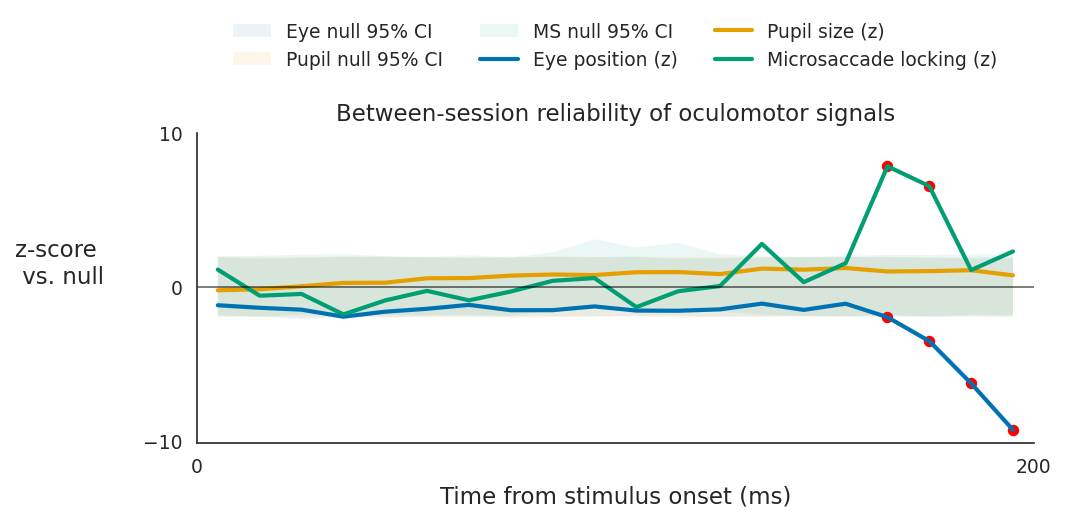

In [ ]:
# -*- coding: utf-8 -*-
"""
Single-panel time courses (z-scored) with 95% null CI shading + cluster-based
significance (cluster-based permutation, two-sided, alpha=0.05)

Using native 10 ms bins across 0–200 ms (20 bins total).

Signals:
- Eye position (between-session Euclidean distance)
- Pupil size (between-session |Δ|)
- Microsaccade direction locking

Output:
- Figures/eye_pupil_microsaccade_zscore_timecourse.pdf
- Statistics/cluster_sig_masks.npz
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------- Config & style -----------------------
T_BINS     = 20          # 20 x 10 ms bins across 200 ms
TRIAL_DUR  = 0.2         # seconds → 200 ms
bin_edges  = np.linspace(0.0, TRIAL_DUR, T_BINS + 1)
time_course_ms = (bin_edges[:-1] + bin_edges[1:]) / 2.0 * 1000  # centers, ms

SEED    = 42
N_PERM  = 1000
ALPHA   = 0.05
THR_Z   = 1.96          # cluster-forming z threshold
FIG_DIR = "Figures"
STATS_DIR = "Statistics"
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(STATS_DIR, exist_ok=True)

plt.rcParams.update({
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "font.size": 10,
    "axes.labelsize": 11,
    "axes.titlesize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.linewidth": 0.8,
})
LINEWIDTH   = 2.0
NULL_SHADE  = 0.08  # alpha for fill_between
rng = np.random.default_rng(SEED)

OKABE_ITO = {
    "blue":   "#0072B2",  # eye
    "orange": "#E69F00",  # pupil
    "green":  "#009E73",  # microsaccade
    "red":    "#D55E00",
}

# ----------------------- Helpers -----------------------------
def z_and_ci(true_vec, perm_mat):
    mu = perm_mat.mean(axis=0)
    sd = perm_mat.std(axis=0, ddof=1)
    sd[sd == 0] = 1.0
    z_true = (true_vec - mu) / sd
    z_perm = (perm_mat - mu) / sd
    ci_low  = np.percentile(z_perm, 2.5, axis=0)
    ci_high = np.percentile(z_perm, 97.5, axis=0)
    return z_true, z_perm, ci_low, ci_high

def _clusters_from_mask(mask):
    idx = np.where(mask)[0]
    if idx.size == 0:
        return []
    cuts = np.where(np.diff(idx) > 1)[0] + 1
    return [seg for seg in np.split(idx, cuts) if seg.size > 0]

def _cluster_masses(zvec, thr, sign="+"):
    if sign == "+":
        mask = zvec >= thr
        clists = _clusters_from_mask(mask)
        masses = [float(np.sum(zvec[c])) for c in clists]
    else:
        mask = zvec <= -thr
        clists = _clusters_from_mask(mask)
        masses = [float(np.sum(-zvec[c])) for c in clists]
    return masses, clists

def cluster_test_1d(z_true, z_perm, thr=1.96, alpha=0.05):
    T = z_true.shape[0]
    null_max_pos = np.zeros(z_perm.shape[0])
    null_max_neg = np.zeros(z_perm.shape[0])
    for i in range(z_perm.shape[0]):
        zpi = z_perm[i]
        mp, _ = _cluster_masses(zpi, thr, sign="+")
        mn, _ = _cluster_masses(zpi, thr, sign="-")
        null_max_pos[i] = np.max(mp) if len(mp) else 0.0
        null_max_neg[i] = np.max(mn) if len(mn) else 0.0

    sig_mask = np.zeros(T, dtype=bool)
    clusters_info = []

    masses_p, clists_p = _cluster_masses(z_true, thr, sign="+")
    for mass, cidx in zip(masses_p, clists_p):
        pval = (np.sum(null_max_pos >= mass) + 1) / (len(null_max_pos) + 1)
        if pval < alpha:
            sig_mask[cidx] = True
            clusters_info.append({"idx": cidx, "p": pval, "sign": "+", "mass": mass})

    masses_n, clists_n = _cluster_masses(z_true, thr, sign="-")
    for mass, cidx in zip(masses_n, clists_n):
        pval = (np.sum(null_max_neg >= mass) + 1) / (len(null_max_neg) + 1)
        if pval < alpha:
            sig_mask[cidx] = True
            clusters_info.append({"idx": cidx, "p": pval, "sign": "-", "mass": mass})

    return sig_mask, clusters_info


# ----------------------- Data loading ------------------------
eye_pos_even_full = np.load("downloads/Mean_eye_position_even_sessions.npy")    # (n_stim,20,2)
eye_pos_odd_full  = np.load("downloads/Mean_eye_position_odd_sessions.npy")     # (n_stim,20,2)
pupil_even_full   = np.load("downloads/Mean_pupil_size_even_sessions.npy")      # (n_stim,20)
pupil_odd_full    = np.load("downloads/Mean_pupil_size_odd_sessions.npy")       # (n_stim,20)

df_saccades_even = pd.read_pickle("downloads/df_saccades_even.pkl")
df_saccades_odd  = pd.read_pickle("downloads/df_saccades_odd.pkl")

n_stim_eye, n_time_eye_full, _ = eye_pos_odd_full.shape
n_stim_pup, n_time_pup_full    = pupil_odd_full.shape
assert n_time_eye_full == T_BINS and n_time_pup_full == T_BINS == 20


# ============================================================
# EYE POSITION (no merging)
# true curve: mean Euclidean distance across stim
# ============================================================
true_eye = np.sqrt(np.sum((eye_pos_odd_full - eye_pos_even_full) ** 2, axis=2)).mean(axis=0)  # (20,)

perm_eye = np.empty((N_PERM, T_BINS), dtype=np.float64)
for p in range(N_PERM):
    idx = rng.permutation(n_stim_eye)
    perm_even = eye_pos_even_full[idx]
    perm_eye[p] = np.sqrt(
        np.sum((eye_pos_odd_full - perm_even) ** 2, axis=2)
    ).mean(axis=0)

z_eye, zperm_eye, cil_eye, cih_eye = z_and_ci(true_eye, perm_eye)
mask_eye, info_eye = cluster_test_1d(z_eye, zperm_eye, thr=THR_Z, alpha=ALPHA)


# ============================================================
# PUPIL SIZE (no merging)
# true curve: mean |Δpupil| across stim
# ============================================================
true_pup = np.abs(pupil_even_full - pupil_odd_full).mean(axis=0)  # (20,)

perm_pup = np.empty((N_PERM, T_BINS), dtype=np.float64)
for p in range(N_PERM):
    idx = rng.permutation(n_stim_pup)
    perm_even = pupil_even_full[idx]
    perm_pup[p] = np.abs(perm_even - pupil_odd_full).mean(axis=0)

z_pup, zperm_pup, cil_pup, cih_pup = z_and_ci(true_pup, perm_pup)
mask_pupil, info_pupil = cluster_test_1d(z_pup, zperm_pup, thr=THR_Z, alpha=ALPHA)


# ============================================================
# MICROSACCADE LOCKING (no merging)
# For each stim and each 10 ms bin:
#   get circular mean of microsaccade directions in odd/even separately
#   fill NaNs with circular mean across stimuli that had data that bin
#   convert to unit complex; take |mean(odd,even)| as locking metric
# ============================================================
n_time_ms_full = T_BINS
mean_dir_odd_full  = np.full((3200, n_time_ms_full), np.nan, dtype=float)
mean_dir_even_full = np.full((3200, n_time_ms_full), np.nan, dtype=float)
bin_edges_ms_10 = bin_edges  # same 10 ms edges

for stimID in range(3200):
    s_odd  = df_saccades_odd[df_saccades_odd.stimId == stimID]
    s_even = df_saccades_even[df_saccades_even.stimId == stimID]
    t_odd  = s_odd["Start_Time"].to_numpy()
    t_even = s_even["Start_Time"].to_numpy()
    a_odd  = s_odd["polar_angle"].to_numpy()
    a_even = s_even["polar_angle"].to_numpy()
    for b in range(n_time_ms_full):
        lo, hi = bin_edges_ms_10[b], bin_edges_ms_10[b+1]
        msk_o = (t_odd > lo) & (t_odd < hi)
        msk_e = (t_even > lo) & (t_even < hi)
        if msk_o.any():
            mean_dir_odd_full[stimID, b]  = np.angle(np.mean(np.exp(1j * a_odd[msk_o])))
        if msk_e.any():
            mean_dir_even_full[stimID, b] = np.angle(np.mean(np.exp(1j * a_even[msk_e])))

# fill NaNs with circular mean across stimuli for each bin
for b in range(n_time_ms_full):
    ok_o = ~np.isnan(mean_dir_odd_full[:, b])
    ok_e = ~np.isnan(mean_dir_even_full[:, b])
    if ok_o.any():
        circ_mean_o = np.angle(np.mean(np.exp(1j * mean_dir_odd_full[ok_o, b])))
        mean_dir_odd_full[~ok_o, b] = circ_mean_o
    else:
        mean_dir_odd_full[:, b] = 0.0
    if ok_e.any():
        circ_mean_e = np.angle(np.mean(np.exp(1j * mean_dir_even_full[ok_e, b])))
        mean_dir_even_full[~ok_e, b] = circ_mean_e
    else:
        mean_dir_even_full[:, b] = 0.0

# to unit complex vectors
v_odd_full  = np.exp(1j * mean_dir_odd_full)   # (3200,20)
v_even_full = np.exp(1j * mean_dir_even_full)  # (3200,20)

# locking metric per bin: |(v_odd + v_even)/2| averaged across stim
true_lock = np.mean(np.abs((v_odd_full + v_even_full) / 2.0), axis=0)  # (20,)

# permutation null: shuffle which even set pairs with odd per stim
perm_lock = np.empty((N_PERM, T_BINS), dtype=np.float64)
for p in range(N_PERM):
    idx = rng.permutation(v_even_full.shape[0])
    v_even_perm = v_even_full[idx]
    perm_lock[p] = np.mean(
        np.abs((v_odd_full + v_even_perm) / 2.0),
        axis=0
    )

z_ms, zperm_ms, cil_ms, cih_ms = z_and_ci(true_lock, perm_lock)
mask_ms, info_ms = cluster_test_1d(z_ms, zperm_ms, thr=THR_Z, alpha=ALPHA)


# ----------------------- Plot ------------------
fig, ax = plt.subplots(1, 1, figsize=(7.2, 3.0))

# shaded null 95% CI for each signal
ax.fill_between(
    time_course_ms, cil_eye, cih_eye,
    alpha=NULL_SHADE,
    facecolor=OKABE_ITO["blue"],
    edgecolor='none',
    label="Eye null 95% CI"
)
ax.fill_between(
    time_course_ms, cil_pup, cih_pup,
    alpha=NULL_SHADE,
    facecolor=OKABE_ITO["orange"],
    edgecolor='none',
    label="Pupil null 95% CI"
)
ax.fill_between(
    time_course_ms, cil_ms, cih_ms,
    alpha=NULL_SHADE,
    facecolor=OKABE_ITO["green"],
    edgecolor='none',
    label="MS null 95% CI"
)

# observed curves
ax.plot(
    time_course_ms, z_eye,
    color=OKABE_ITO["blue"], lw=LINEWIDTH,
    label="Eye position (z)"
)
ax.plot(
    time_course_ms, z_pup,
    color=OKABE_ITO["orange"], lw=LINEWIDTH,
    label="Pupil size (z)"
)
ax.plot(
    time_course_ms, z_ms,
    color=OKABE_ITO["green"], lw=LINEWIDTH,
    label="Microsaccade locking (z)"
)

# significant time bins (cluster corrected)
ax.scatter(time_course_ms[mask_eye],   z_eye[mask_eye],   color='red', s=20)
ax.scatter(time_course_ms[mask_pupil], z_pup[mask_pupil], color='red', s=20)
ax.scatter(time_course_ms[mask_ms],    z_ms[mask_ms],     color='red', s=20)

# cosmetics
ax.axhline(0, color='k', lw=0.8, alpha=0.6)
ax.set_xlim(0, 200)
ax.set_xticks([0, 200])
ax.set_yticks([-10, 0, 10])
ax.set_xlabel("Time from stimulus onset (ms)")
ax.set_ylabel("z-score \n vs. null",rotation = 0, labelpad = 40)
ax.set_title("Between-session reliability of oculomotor signals")

# legend above plot, dedup labels
handles, labels = ax.get_legend_handles_labels()
uniq = dict(zip(labels, handles))
ax.legend(
    uniq.values(),
    uniq.keys(),
    frameon=False,
    loc="lower center",
    bbox_to_anchor=(0.5, 1.15),
    ncol=3
)
fig.subplots_adjust(top=0.8)

# save
out_path = os.path.join(
    FIG_DIR,
    "eye_pupil_microsaccade_zscore_timecourse.pdf"
)
fig.savefig(out_path, bbox_inches="tight")
print(f"Saved: {out_path}")

# save masks + time axis
np.savez(
    os.path.join(STATS_DIR, "cluster_sig_masks.npz"),
    mask_eye=mask_eye,
    mask_pupil=mask_pupil,
    mask_ms=mask_ms,
    time_course_ms=time_course_ms
)

# console summaries
def _summ(info, label):
    if not info:
        print(f"{label}: no significant clusters.")
        return
    print(f"{label}:")
    for c in info:
        st, en = c["idx"][0], c["idx"][-1]
        t0, t1 = time_course_ms[st], time_course_ms[en]
        print(f"  sign {c['sign']}, p={c['p']:.4f}, mass={c['mass']:.2f}, "
              f"bins {st}-{en} → {t0:.1f}–{t1:.1f} ms")

_summ(info_eye,   "Eye")
_summ(info_pupil, "Pupil")
_summ(info_ms,    "Microsaccade")

# Consistency of eye signal without late MS and major eye drift

Saved: Figures/eye_pupil_microsaccade_zscore_timecourse_ms_free.pdf
Eye: no significant clusters.
Pupil: no significant clusters.
Microsaccade: no significant clusters.


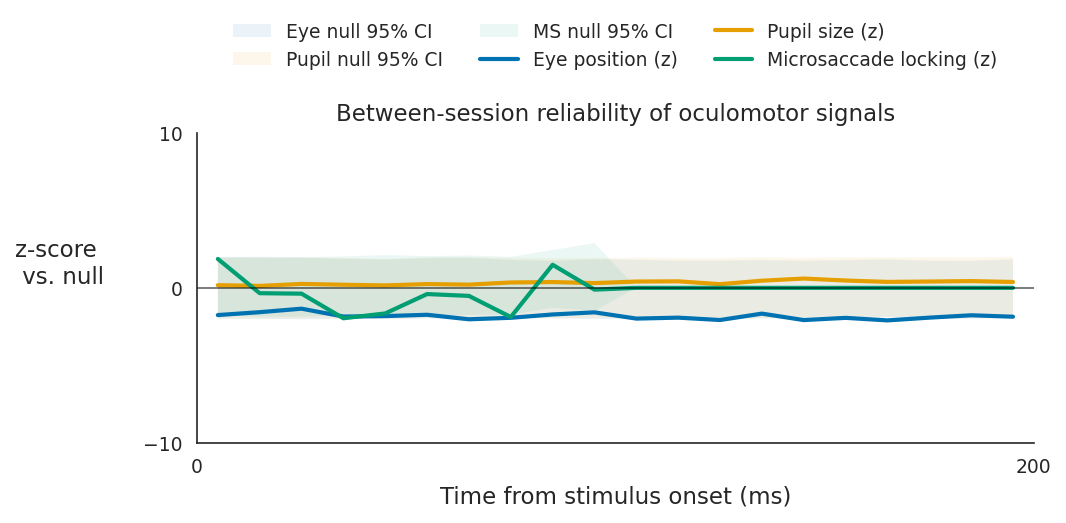

In [ ]:
# -*- coding: utf-8 -*-
"""
Single-panel time courses (z-scored) with 95% null CI shading + cluster-based
significance (cluster-based permutation, two-sided, alpha=0.05)

Using native 10 ms bins across 0–200 ms (20 bins total).

Signals:
- Eye position (between-session Euclidean distance)
- Pupil size (between-session |Δ|)
- Microsaccade direction locking

Output:
- Figures/eye_pupil_microsaccade_zscore_timecourse_ms_free.pdf
- Statistics/cluster_sig_masks.npz
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------- Config & style -----------------------
T_BINS     = 20          # 20 x 10 ms bins across 200 ms
TRIAL_DUR  = 0.2         # seconds → 200 ms
bin_edges  = np.linspace(0.0, TRIAL_DUR, T_BINS + 1)
time_course_ms = (bin_edges[:-1] + bin_edges[1:]) / 2.0 * 1000  # centers, ms

SEED    = 42
N_PERM  = 1000
ALPHA   = 0.05
THR_Z   = 1.96          # cluster-forming z threshold
FIG_DIR = "Figures"
STATS_DIR = "Statistics"
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(STATS_DIR, exist_ok=True)

plt.rcParams.update({
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "font.size": 10,
    "axes.labelsize": 11,
    "axes.titlesize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.linewidth": 0.8,
})
LINEWIDTH   = 2.0
NULL_SHADE  = 0.08  # alpha for fill_between
rng = np.random.default_rng(SEED)

OKABE_ITO = {
    "blue":   "#0072B2",  # eye
    "orange": "#E69F00",  # pupil
    "green":  "#009E73",  # microsaccade
    "red":    "#D55E00",
}

# ----------------------- Helpers -----------------------------
def z_and_ci(true_vec, perm_mat):
    mu = perm_mat.mean(axis=0)
    sd = perm_mat.std(axis=0, ddof=1)
    sd[sd == 0] = 1.0
    z_true = (true_vec - mu) / sd
    z_perm = (perm_mat - mu) / sd
    ci_low  = np.percentile(z_perm, 2.5, axis=0)
    ci_high = np.percentile(z_perm, 97.5, axis=0)
    return z_true, z_perm, ci_low, ci_high

def _clusters_from_mask(mask):
    idx = np.where(mask)[0]
    if idx.size == 0:
        return []
    cuts = np.where(np.diff(idx) > 1)[0] + 1
    return [seg for seg in np.split(idx, cuts) if seg.size > 0]

def _cluster_masses(zvec, thr, sign="+"):
    if sign == "+":
        mask = zvec >= thr
        clists = _clusters_from_mask(mask)
        masses = [float(np.sum(zvec[c])) for c in clists]
    else:
        mask = zvec <= -thr
        clists = _clusters_from_mask(mask)
        masses = [float(np.sum(-zvec[c])) for c in clists]
    return masses, clists

def cluster_test_1d(z_true, z_perm, thr=1.96, alpha=0.05):
    T = z_true.shape[0]
    null_max_pos = np.zeros(z_perm.shape[0])
    null_max_neg = np.zeros(z_perm.shape[0])
    for i in range(z_perm.shape[0]):
        zpi = z_perm[i]
        mp, _ = _cluster_masses(zpi, thr, sign="+")
        mn, _ = _cluster_masses(zpi, thr, sign="-")
        null_max_pos[i] = np.max(mp) if len(mp) else 0.0
        null_max_neg[i] = np.max(mn) if len(mn) else 0.0

    sig_mask = np.zeros(T, dtype=bool)
    clusters_info = []

    masses_p, clists_p = _cluster_masses(z_true, thr, sign="+")
    for mass, cidx in zip(masses_p, clists_p):
        pval = (np.sum(null_max_pos >= mass) + 1) / (len(null_max_pos) + 1)
        if pval < alpha:
            sig_mask[cidx] = True
            clusters_info.append({"idx": cidx, "p": pval, "sign": "+", "mass": mass})

    masses_n, clists_n = _cluster_masses(z_true, thr, sign="-")
    for mass, cidx in zip(masses_n, clists_n):
        pval = (np.sum(null_max_neg >= mass) + 1) / (len(null_max_neg) + 1)
        if pval < alpha:
            sig_mask[cidx] = True
            clusters_info.append({"idx": cidx, "p": pval, "sign": "-", "mass": mass})

    return sig_mask, clusters_info


# ----------------------- Data loading ------------------------
eye_pos_even_full = np.load("downloads/Mean_eye_position_even_sessions_ms_free.npy")    # (n_stim,20,2)
eye_pos_odd_full  = np.load("downloads/Mean_eye_position_odd_sessions_ms_free.npy")     # (n_stim,20,2)
pupil_even_full   = np.load("downloads/Mean_pupil_size_even_sessions_ms_free.npy")      # (n_stim,20)
pupil_odd_full    = np.load("downloads/Mean_pupil_size_odd_sessions_ms_free.npy")       # (n_stim,20)
valid_mask_ms_free = np.load("downloads/valid_mask_ms_free.npy")
df_saccades_even = pd.read_pickle("downloads/df_saccades_even.pkl")
df_saccades_odd  = pd.read_pickle("downloads/df_saccades_odd.pkl")

df_saccades_even_ms_free = df_saccades_even[df_saccades_even['Trial'].isin(np.where(valid_mask_ms_free)[0])].copy()
df_saccades_odd_ms_free  = df_saccades_odd[df_saccades_odd['Trial'].isin(np.where(valid_mask_ms_free)[0])].copy()

n_stim_eye, n_time_eye_full, _ = eye_pos_odd_full.shape
n_stim_pup, n_time_pup_full    = pupil_odd_full.shape
assert n_time_eye_full == T_BINS and n_time_pup_full == T_BINS == 20


# ============================================================
# EYE POSITION (no merging)
# true curve: mean Euclidean distance across stim
# ============================================================
true_eye = np.sqrt(np.sum((eye_pos_odd_full - eye_pos_even_full) ** 2, axis=2)).mean(axis=0)  # (20,)

perm_eye = np.empty((N_PERM, T_BINS), dtype=np.float64)
for p in range(N_PERM):
    idx = rng.permutation(n_stim_eye)
    perm_even = eye_pos_even_full[idx]
    perm_eye[p] = np.sqrt(
        np.sum((eye_pos_odd_full - perm_even) ** 2, axis=2)
    ).mean(axis=0)

z_eye, zperm_eye, cil_eye, cih_eye = z_and_ci(true_eye, perm_eye)
mask_eye, info_eye = cluster_test_1d(z_eye, zperm_eye, thr=THR_Z, alpha=ALPHA)


# ============================================================
# PUPIL SIZE (no merging)
# true curve: mean |Δpupil| across stim
# ============================================================
true_pup = np.abs(pupil_even_full - pupil_odd_full).mean(axis=0)  # (20,)

perm_pup = np.empty((N_PERM, T_BINS), dtype=np.float64)
for p in range(N_PERM):
    idx = rng.permutation(n_stim_pup)
    perm_even = pupil_even_full[idx]
    perm_pup[p] = np.abs(perm_even - pupil_odd_full).mean(axis=0)

z_pup, zperm_pup, cil_pup, cih_pup = z_and_ci(true_pup, perm_pup)
mask_pupil, info_pupil = cluster_test_1d(z_pup, zperm_pup, thr=THR_Z, alpha=ALPHA)


# ============================================================
# MICROSACCADE LOCKING (no merging)
# For each stim and each 10 ms bin:
#   get circular mean of microsaccade directions in odd/even separately
#   fill NaNs with circular mean across stimuli that had data that bin
#   convert to unit complex; take |mean(odd,even)| as locking metric
# ============================================================
n_time_ms_full = T_BINS
mean_dir_odd_full  = np.full((3200, n_time_ms_full), np.nan, dtype=float)
mean_dir_even_full = np.full((3200, n_time_ms_full), np.nan, dtype=float)
bin_edges_ms_10 = bin_edges  # same 10 ms edges

for stimID in range(3200):
    s_odd  = df_saccades_odd_ms_free[df_saccades_odd_ms_free.stimId == stimID]
    s_even = df_saccades_even_ms_free[df_saccades_even_ms_free.stimId == stimID]
    t_odd  = s_odd["Start_Time"].to_numpy()
    t_even = s_even["Start_Time"].to_numpy()
    a_odd  = s_odd["polar_angle"].to_numpy()
    a_even = s_even["polar_angle"].to_numpy()
    for b in range(n_time_ms_full):
        lo, hi = bin_edges_ms_10[b], bin_edges_ms_10[b+1]
        msk_o = (t_odd > lo) & (t_odd < hi)
        msk_e = (t_even > lo) & (t_even < hi)
        if msk_o.any():
            mean_dir_odd_full[stimID, b]  = np.angle(np.mean(np.exp(1j * a_odd[msk_o])))
        if msk_e.any():
            mean_dir_even_full[stimID, b] = np.angle(np.mean(np.exp(1j * a_even[msk_e])))

# fill NaNs with circular mean across stimuli for each bin
for b in range(n_time_ms_full):
    ok_o = ~np.isnan(mean_dir_odd_full[:, b])
    ok_e = ~np.isnan(mean_dir_even_full[:, b])
    if ok_o.any():
        circ_mean_o = np.angle(np.mean(np.exp(1j * mean_dir_odd_full[ok_o, b])))
        mean_dir_odd_full[~ok_o, b] = circ_mean_o
    else:
        mean_dir_odd_full[:, b] = 0.0
    if ok_e.any():
        circ_mean_e = np.angle(np.mean(np.exp(1j * mean_dir_even_full[ok_e, b])))
        mean_dir_even_full[~ok_e, b] = circ_mean_e
    else:
        mean_dir_even_full[:, b] = 0.0

# to unit complex vectors
v_odd_full  = np.exp(1j * mean_dir_odd_full)   # (3200,20)
v_even_full = np.exp(1j * mean_dir_even_full)  # (3200,20)

# locking metric per bin: |(v_odd + v_even)/2| averaged across stim
true_lock = np.mean(np.abs((v_odd_full + v_even_full) / 2.0), axis=0)  # (20,)

# permutation null: shuffle which even set pairs with odd per stim
perm_lock = np.empty((N_PERM, T_BINS), dtype=np.float64)
for p in range(N_PERM):
    idx = rng.permutation(v_even_full.shape[0])
    v_even_perm = v_even_full[idx]
    perm_lock[p] = np.mean(
        np.abs((v_odd_full + v_even_perm) / 2.0),
        axis=0
    )

z_ms, zperm_ms, cil_ms, cih_ms = z_and_ci(true_lock, perm_lock)
mask_ms, info_ms = cluster_test_1d(z_ms, zperm_ms, thr=THR_Z, alpha=ALPHA)


# ----------------------- Plot ------------------
fig, ax = plt.subplots(1, 1, figsize=(7.2, 3.0))

# shaded null 95% CI for each signal
ax.fill_between(
    time_course_ms, cil_eye, cih_eye,
    alpha=NULL_SHADE,
    facecolor=OKABE_ITO["blue"],
    edgecolor='none',
    label="Eye null 95% CI"
)
ax.fill_between(
    time_course_ms, cil_pup, cih_pup,
    alpha=NULL_SHADE,
    facecolor=OKABE_ITO["orange"],
    edgecolor='none',
    label="Pupil null 95% CI"
)
ax.fill_between(
    time_course_ms, cil_ms, cih_ms,
    alpha=NULL_SHADE,
    facecolor=OKABE_ITO["green"],
    edgecolor='none',
    label="MS null 95% CI"
)

# observed curves
ax.plot(
    time_course_ms, z_eye,
    color=OKABE_ITO["blue"], lw=LINEWIDTH,
    label="Eye position (z)"
)
ax.plot(
    time_course_ms, z_pup,
    color=OKABE_ITO["orange"], lw=LINEWIDTH,
    label="Pupil size (z)"
)
ax.plot(
    time_course_ms, z_ms,
    color=OKABE_ITO["green"], lw=LINEWIDTH,
    label="Microsaccade locking (z)"
)

# significant time bins (cluster corrected)
ax.scatter(time_course_ms[mask_eye],   z_eye[mask_eye],   color='red', s=20)
ax.scatter(time_course_ms[mask_pupil], z_pup[mask_pupil], color='red', s=20)
ax.scatter(time_course_ms[mask_ms],    z_ms[mask_ms],     color='red', s=20)

# cosmetics
ax.axhline(0, color='k', lw=0.8, alpha=0.6)
ax.set_xlim(0, 200)
ax.set_xticks([0, 200])
ax.set_yticks([-10, 0, 10])
ax.set_xlabel("Time from stimulus onset (ms)")
ax.set_ylabel("z-score \n vs. null",rotation = 0, labelpad = 40)
ax.set_title("Between-session reliability of oculomotor signals")

# legend above plot, dedup labels
handles, labels = ax.get_legend_handles_labels()
uniq = dict(zip(labels, handles))
ax.legend(
    uniq.values(),
    uniq.keys(),
    frameon=False,
    loc="lower center",
    bbox_to_anchor=(0.5, 1.15),
    ncol=3
)
fig.subplots_adjust(top=0.8)

# save
out_path = os.path.join(
    FIG_DIR,
    "eye_pupil_microsaccade_zscore_timecourse_ms_free.pdf"
)
fig.savefig(out_path, bbox_inches="tight")
print(f"Saved: {out_path}")

# save masks + time axis
np.savez(
    os.path.join(STATS_DIR, "cluster_sig_masks.npz"),
    mask_eye=mask_eye,
    mask_pupil=mask_pupil,
    mask_ms=mask_ms,
    time_course_ms=time_course_ms
)

# console summaries
def _summ(info, label):
    if not info:
        print(f"{label}: no significant clusters.")
        return
    print(f"{label}:")
    for c in info:
        st, en = c["idx"][0], c["idx"][-1]
        t0, t1 = time_course_ms[st], time_course_ms[en]
        print(f"  sign {c['sign']}, p={c['p']:.4f}, mass={c['mass']:.2f}, "
              f"bins {st}-{en} → {t0:.1f}-{t1:.1f} ms")

_summ(info_eye,   "Eye")
_summ(info_pupil, "Pupil")
_summ(info_ms,    "Microsaccade")

# Plot eye velocity with and without microsaccades

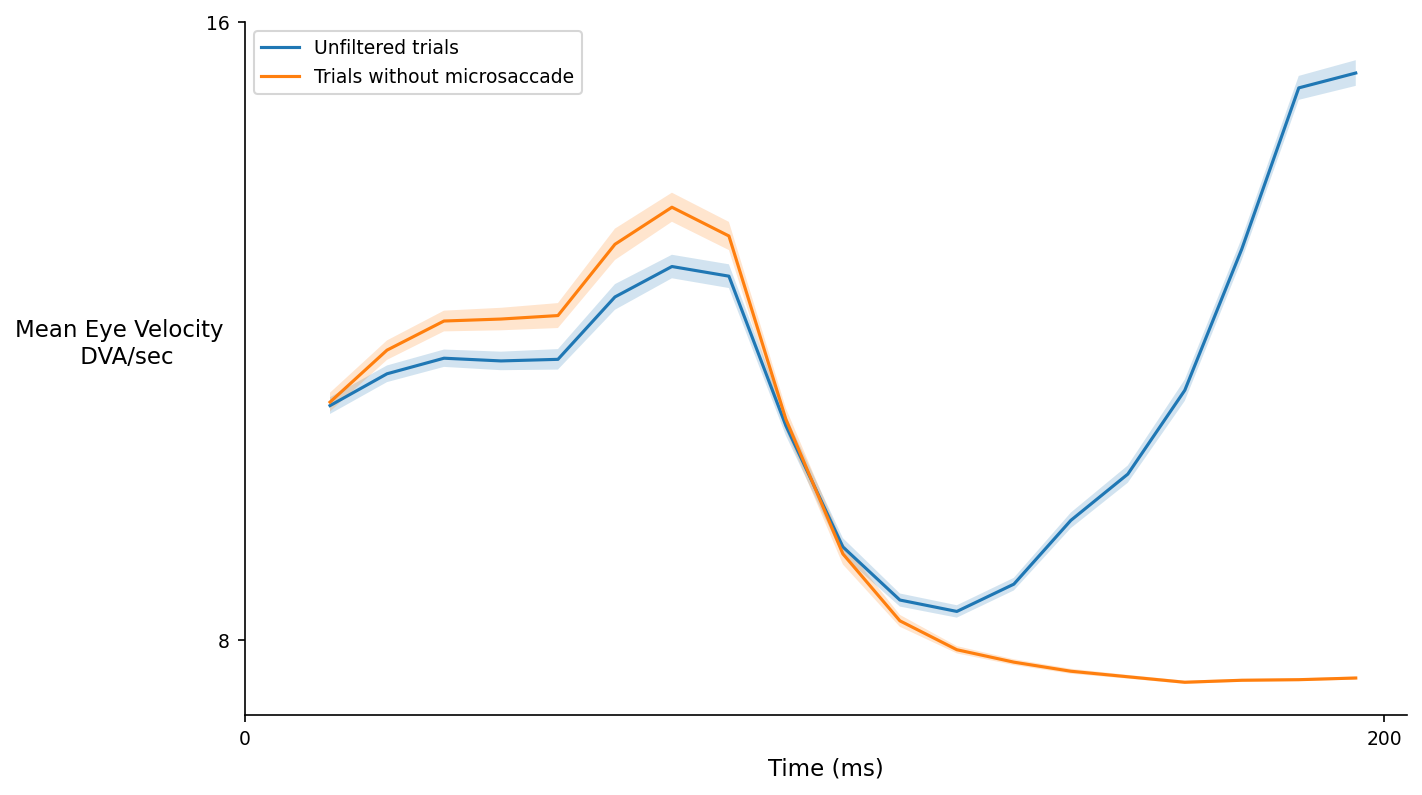

In [ ]:
from matplotlib import pyplot as plt
from scipy import stats
import numpy as np

aggregated_eye_pos = np.load('downloads/aggregated_eye_pos.npy')
valid_mask_ms_free = np.load('downloads/valid_mask_ms_free.npy')
valid_mask = np.load('downloads/valid_mask.npy')
time_ms = np.arange(15,205,10)
eye_velocity = np.sqrt(np.sum(np.diff(aggregated_eye_pos,axis=1)**2,2))
# convert eye_velocity into DVA per seconds
eye_velocity = eye_velocity*100
velocity_valid = eye_velocity[valid_mask, :]
velocity_valid_ms_free = eye_velocity[valid_mask_ms_free, :]



# Calculate mean and SEM for valid_mask
mean_valid = np.mean(velocity_valid, axis=0)
sem_valid = np.std(velocity_valid, axis=0) / np.sqrt(velocity_valid.shape[0])

# Calculate mean and SEM for valid_mask_ms_free
mean_ms_free = np.mean(velocity_valid_ms_free, axis=0)
sem_ms_free = np.std(velocity_valid_ms_free, axis=0) / np.sqrt(velocity_valid_ms_free.shape[0])


fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(time_ms, mean_valid, label='Unfiltered trials')
plt.fill_between(time_ms, mean_valid - sem_valid, mean_valid + sem_valid, alpha=0.2)

plt.plot(time_ms, mean_ms_free, label='Trials without microsaccade')
plt.fill_between(time_ms, mean_ms_free - sem_ms_free, mean_ms_free + sem_ms_free, alpha=0.2)


plt.legend()
# despine
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.yticks([8,16])
plt.xticks([0,200])
plt.xlabel('Time (ms)')
plt.ylabel('Mean Eye Velocity \n DVA/sec',rotation = 0, labelpad= 40)
plt.show()
fig.savefig('Figures/eye_velocity.pdf', dpi=300, bbox_inches='tight')

# Geometry Dynamics MS_free

Run 1/10 done (pair-unique).
Run 2/10 done (pair-unique).
Run 3/10 done (pair-unique).
Run 4/10 done (pair-unique).
Run 5/10 done (pair-unique).
Run 6/10 done (pair-unique).
Run 7/10 done (pair-unique).
Run 8/10 done (pair-unique).
Run 9/10 done (pair-unique).
Run 10/10 done (pair-unique).


<Figure size 2040x2400 with 0 Axes>

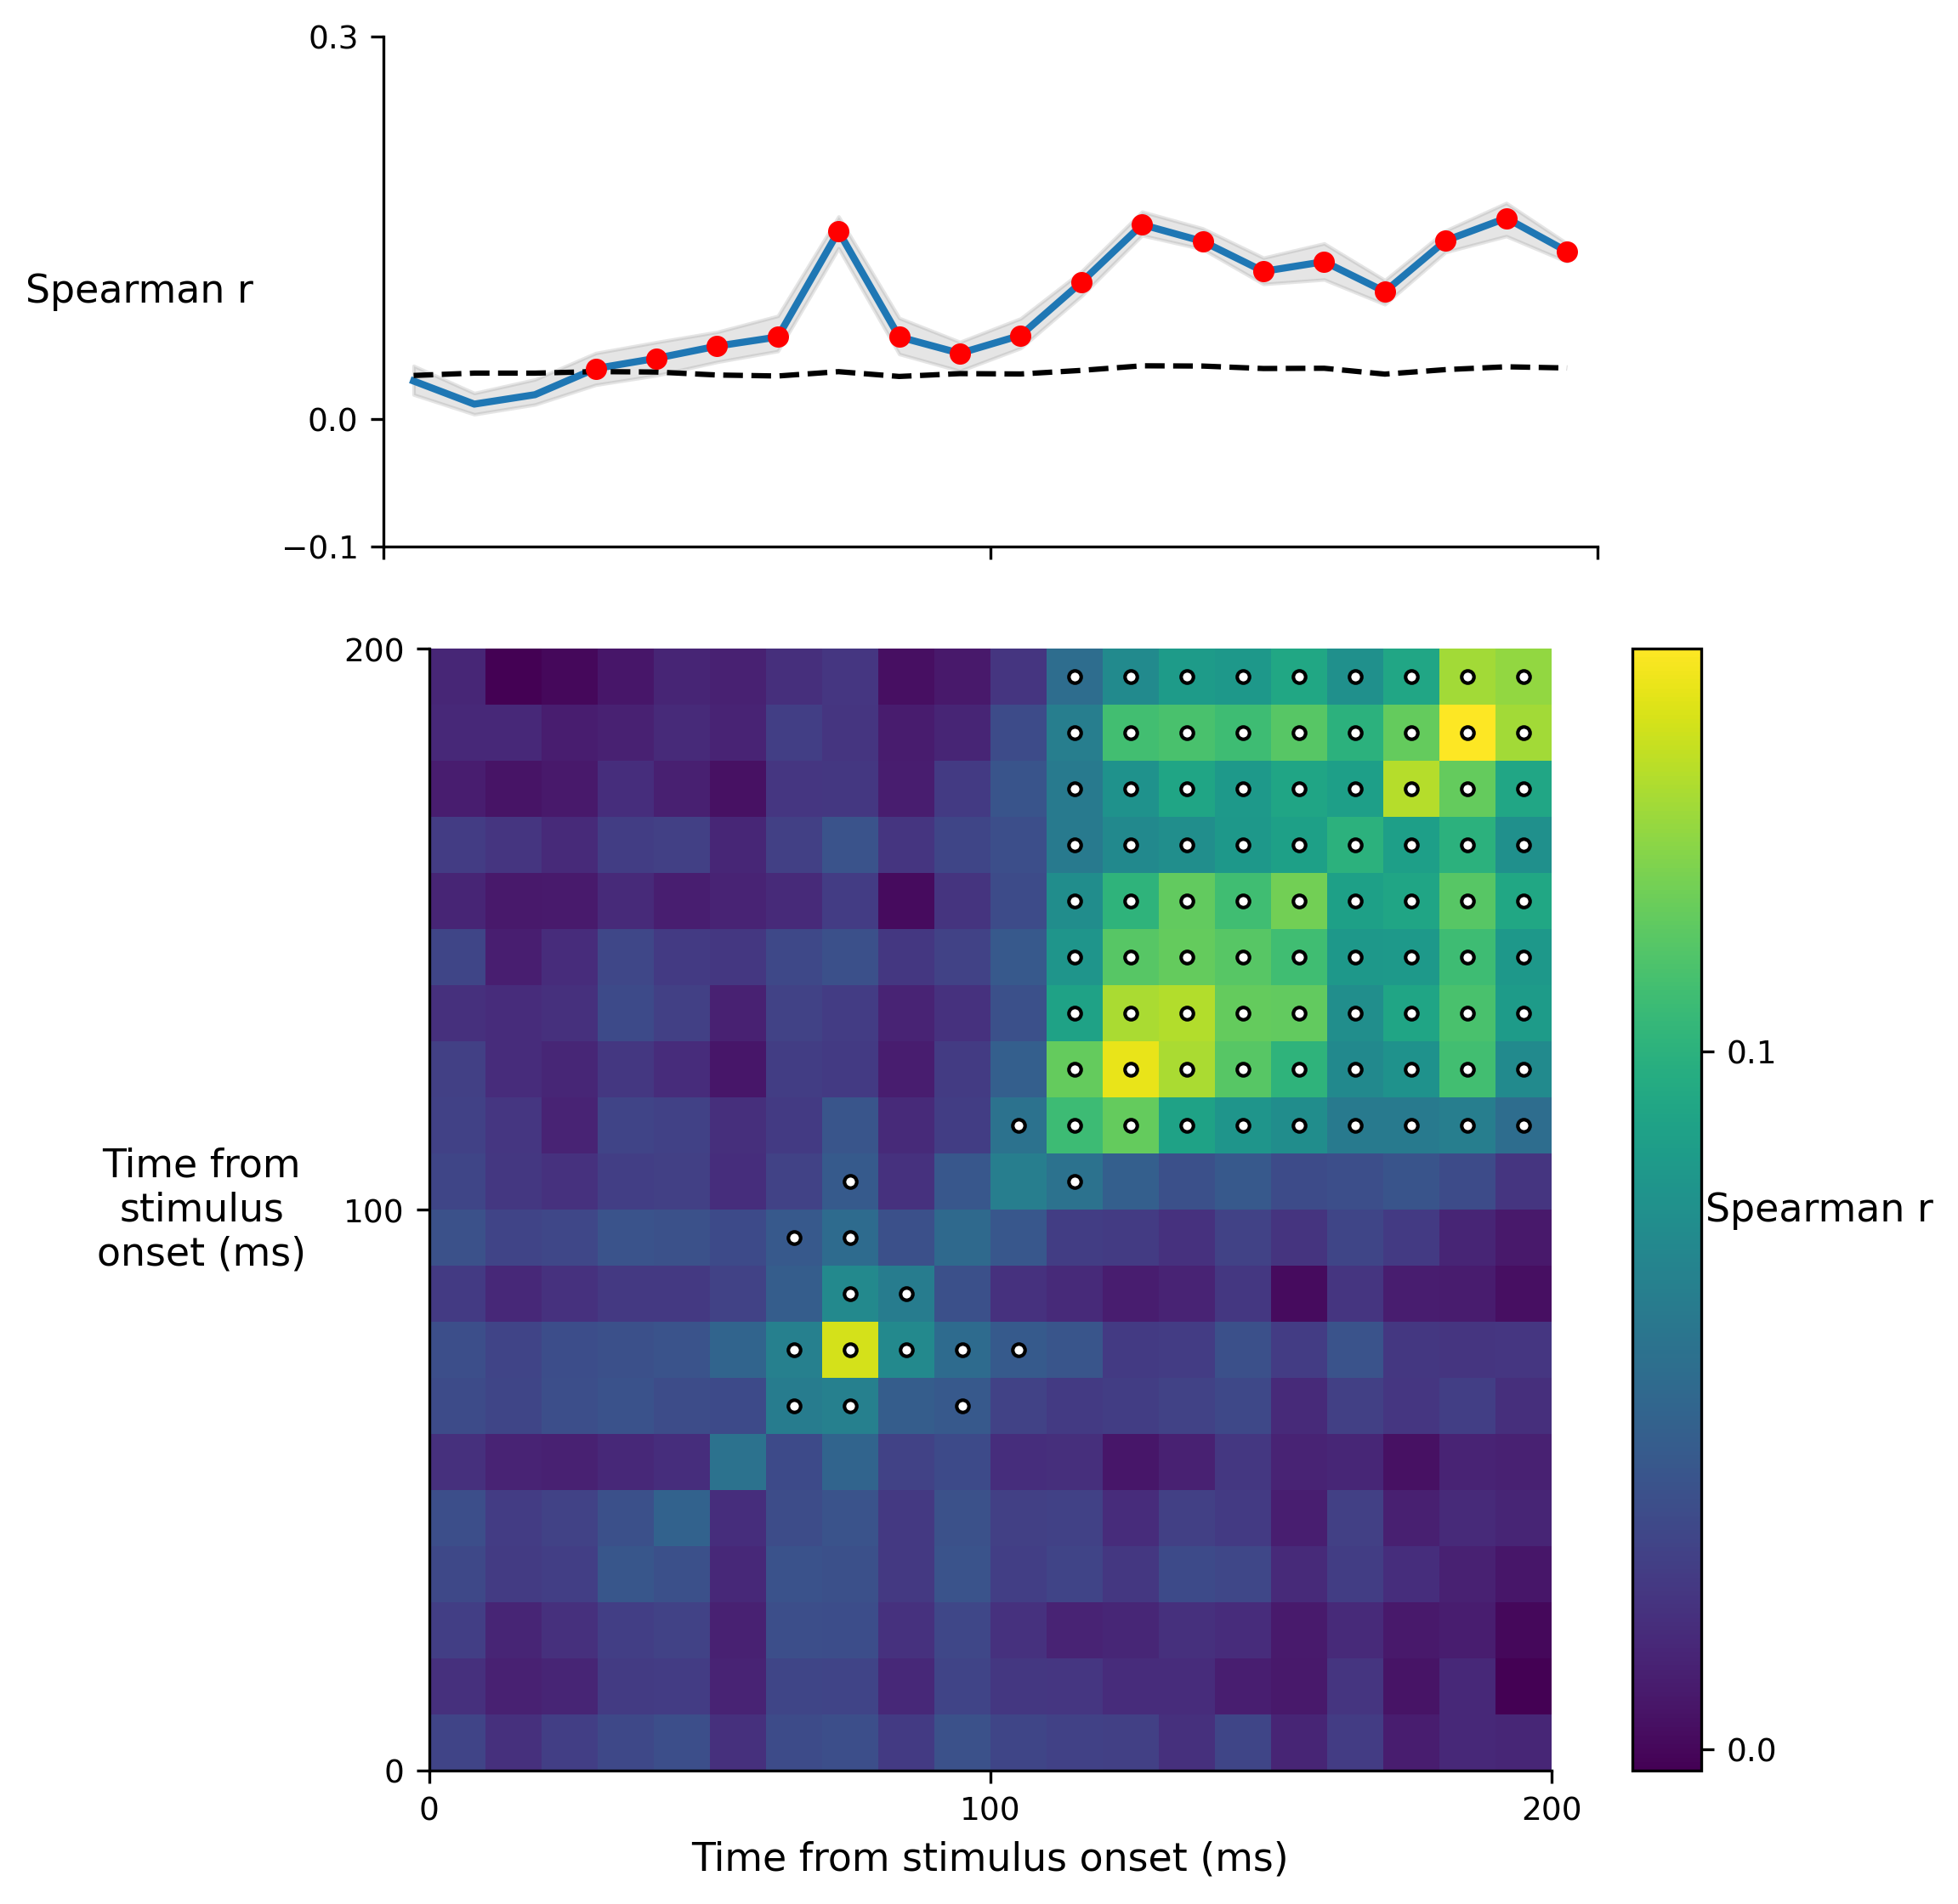

In [ ]:

# 0. Parameters
batch_size   = 16          # fixed (→ 16 pairs per batch)
n_runs       = 10          # first 10 round-robin rounds → 10 pair-unique runs
n_surrogates = 2_000       # per run
alpha        = 0.05
skip_first   = 640         # Only include high-variation stimuli

# 1. Imports
import numpy as np, jax, jax.numpy as jnp
import matplotlib.pyplot as plt, seaborn as sns
from itertools import combinations
from scipy.stats import rankdata
from statsmodels.stats.multitest import multipletests
import subprocess, pathlib, warnings
warnings.filterwarnings("ignore", category=FutureWarning)

rng_global   = np.random.default_rng(42)

# 2. Helpers
def _upper(n):
    iu, ju = np.triu_indices(n, 1)
    return tuple(iu.tolist()), tuple(ju.tolist())

def make_pw_euclid(batch):
    iu, ju = _upper(batch)
    def _pw(X, *, iu=iu, ju=ju):
        iu_a, ju_a = jnp.array(iu), jnp.array(ju)
        diff = X[:, None, :] - X[None, :, :]
        return jnp.sum(diff**2, axis=-1)[iu_a, ju_a]
    return jax.jit(_pw, static_argnames=("iu", "ju"))

def rank_safe(a):
    if a.ndim == 1:
        return rankdata(a)
    return np.vstack([rankdata(a[:, i]) for i in range(a.shape[1])]).T

def batch_rdm(data, idx, pw):
    X, T = data[idx], data.shape[-1]
    r = np.empty((len(idx)*(len(idx)-1)//2, T), np.float64)
    for t in range(T):
        r[:, t] = np.asarray(pw(jnp.asarray(X[:, :, t])))
    return r

def fdr_triu(p_mat, *, alpha=0.05):
    """
    Run BH-FDR on the upper triangle (including the diagonal) of a square
    p-value matrix and mirror results to full size.
    Returns: sig_mask (bool, same shape as p_mat), q_full (float, same shape)
    """
    iu, ju = np.triu_indices_from(p_mat, k=0)
    pvec   = p_mat[iu, ju]
    reject, qvec, *_ = multipletests(pvec, alpha=alpha, method="fdr_bh")
    sig  = np.zeros_like(p_mat, dtype=bool)
    qmat = np.ones_like(p_mat, dtype=float)
    sig[iu, ju] = reject
    qmat[iu, ju] = qvec
    # mirror to lower triangle
    sig[ju, iu] = sig[iu, ju]
    qmat[ju, iu] = qmat[iu, ju]
    return sig, qmat

# 3. Round-robin “speed-dating” pairs  -----------------------------------
def round_robin_pairs(n, rng):
    players = list(range(n))
    rounds = []
    for r in range(n - 1):
        pairs = [(players[i], players[-i-1]) for i in range(n // 2)]
        rng.shuffle(pairs)
        rounds.append(pairs)
        players = [players[0]] + [players[-1]] + players[1:-1]
    return rounds

def round_to_batches(pairs_round):
    pairs_round = list(pairs_round)
    batches = []
    for i in range(0, len(pairs_round), 8):
        chunk = pairs_round[i:i+8]
        flat  = [j for p in chunk for j in p]
        batches.append(np.array(flat, dtype=int))
    return batches

# 4. Single-run RSA functions (internal permutation) ---------------------
def timecourse_once(odd, even, batches, rng):
    T  = odd.shape[-1]
    pw = make_pw_euclid(batch_size)
    real = np.empty((len(batches), T), np.float64)
    diff = np.empty_like(real)

    for g, idx in enumerate(batches):
        idx_p = rng.permutation(idx)
        ro, re = (batch_rdm(d, idx,  pw) for d in (odd, even))
        rop    = batch_rdm(odd, idx_p, pw)
        ro, re, rop = map(rank_safe, (ro, re, rop))
        for t in range(T):
            r1 = np.corrcoef(ro[:, t], re[:, t])[0, 1]
            r0 = np.corrcoef(rop[:, t], re[:, t])[0, 1]
            real[g, t] = r1
            diff[g, t] = r1 - r0

    mean_r = real.mean(axis=0)
    surr   = np.empty((n_surrogates, T), np.float64)
    for s in range(n_surrogates):
        surr[s] = (diff * rng.choice([-1, 1], size=(len(batches), 1))).mean(axis=0)
    return mean_r, surr

def crosstemp_once(odd, even, batches, rng):
    T  = odd.shape[-1]
    pw = make_pw_euclid(batch_size)
    actual = np.empty((len(batches), T, T), np.float64)
    null   = np.empty_like(actual)

    for g, idx in enumerate(batches):
        idx_p = rng.permutation(idx)
        ro, re = (batch_rdm(d, idx,  pw) for d in (odd, even))
        rop    = batch_rdm(odd, idx_p, pw)
        ro, re, rop = map(rank_safe, (ro, re, rop))
        A  = jnp.hstack([jnp.asarray(ro),  jnp.asarray(re)])
        Ap = jnp.hstack([jnp.asarray(rop), jnp.asarray(re)])
        ca = jnp.corrcoef(A,  rowvar=False)
        cp = jnp.corrcoef(Ap, rowvar=False)
        actual[g] = np.asarray(ca[:T, T:])
        null[g]   = np.asarray(cp[:T, T:])

    mean_ct = actual.mean(axis=0)
    mean_ct = 0.5 * (mean_ct + mean_ct.T)          # enforce symmetry
    surr = np.empty((n_surrogates, T, T), np.float64)
    for s in range(n_surrogates):
        coin   = rng.choice([True, False], size=len(batches))
        surr_s = np.mean(np.where(coin[:, None, None], actual, null), axis=0)
        surr[s] = 0.5 * (surr_s + surr_s.T)
    return mean_ct, surr

# 5. Slice data -----------------------------------------------

time_course = np.arange(0, 200, 10)+5 # centering bins
even = np.load("downloads/Spike_count_even_sessions_ms_free.npy")[skip_first:]
odd  = np.load("downloads/Spike_count_odd_sessions_ms_free.npy")[skip_first:]
n_stim = odd.shape[0]   # 2 560

# 6. Build pair-unique partitions ----------------------------------------
pairs_rounds = round_robin_pairs(n_stim, rng_global)
runs_batches = [round_to_batches(pairs_rounds[r]) for r in range(n_runs)]

# 7. Monte-Carlo loop ----------------------------------------------------
diag_runs, diag_surr = [], []
ct_runs,   ct_surr   = [], []

for r, batches in enumerate(runs_batches):
    rng = np.random.default_rng(rng_global.integers(2**32))
    m_r, s_r   = timecourse_once(odd, even, batches, rng)
    m_ct, s_ct = crosstemp_once(odd, even, batches, rng)
    diag_runs.append(m_r);  diag_surr.append(s_r)
    ct_runs.append(m_ct);   ct_surr.append(s_ct)
    print(f"Run {r+1}/{n_runs} done (pair-unique).")

diag_runs = np.stack(diag_runs)
ct_runs   = np.stack(ct_runs)

grand_r   = diag_runs.mean(axis=0)
grand_sem = diag_runs.std(axis=0, ddof=1) / np.sqrt(n_runs)
qlo, qhi  = np.percentile(diag_runs, [2.5, 97.5], axis=0)
grand_ct  = ct_runs.mean(axis=0)

# 7a. FDR: 1-D diagonal --------------------------------------
diag_surr_all = np.concatenate(diag_surr, axis=0)
sig_diag = multipletests((diag_surr_all >= grand_r).mean(axis=0),
                         alpha=alpha, method="fdr_bh")[0]

# 7b. FDR: cross-temporal — upper triangle only --------------------------
ct_surr_all = np.concatenate(ct_surr, axis=0)
p_ct = (ct_surr_all >= grand_ct).mean(axis=0)   # raw p-values (T×T)
sig_ct, q_ct = fdr_triu(p_ct, alpha=alpha)

# 8. Plot ---------------------------------------------------------------
time_course = np.arange(0, 200, 10)+5 # centering bins
plt.rcParams.update({"figure.dpi":300, "axes.spines.top":False,
                     "axes.spines.right":False, "font.size":11})
fig = plt.figure(figsize=(6.8, 8))
L,W = 0.15, 0.70
R   = L + W
bB,hB = 0.10,0.55
bA,hA = bB + hB + 0.05, 0.25

# 8. Plot ---------------------------------------------------------------
time_course = np.arange(0, 200, 10)+5 # centering bins
plt.rcParams.update({"figure.dpi":300, "axes.spines.top":False,
                     "axes.spines.right":False, "font.size":11})
fig = plt.figure(figsize=(6.8, 8))
L,W = 0.15, 0.70
R   = L + W
bB,hB = 0.10,0.55
bA,hA = bB + hB + 0.05, 0.25

# Panel A – time-course
ax1 = fig.add_axes([L, bA, W, hA])
ax1.plot(time_course, grand_r, lw=2, label="Grand mean")
ax1.fill_between(time_course, qlo, qhi, color="grey", alpha=0.2,
                 label="95 % CI")
ax1.plot(time_course,np.percentile(diag_surr_all,95,axis=0),'k--',label = '95% Surrogate')
ax1.plot(time_course[sig_diag], grand_r[sig_diag], "ro", ms=5,
         label="FDR-significant")
ax1.set_xlim(0,200); ax1.set_xticks([0,100,200])
ax1.set_yticks([-.1,0,.3])
ax1.tick_params(axis="x", bottom=True, labelbottom=False)
ax1.set_ylabel("Spearman r", rotation=0,
               labelpad=40, va="center")
sns.despine(ax=ax1, trim=True)

# Panel B – cross-temporal matrix
ax2 = fig.add_axes([L, bB, W, hB])
im = ax2.imshow(grand_ct, origin="lower", cmap="viridis",
                extent=[0,200,0,200], interpolation="none")
ax2.set_aspect("equal")
ax2.set_xlim(0,200); ax2.set_ylim(0,200)
ax2.set_xticks([0,100,200]); ax2.set_yticks([0,100,200])
ax2.set_xlabel("Time from stimulus onset (ms)")
ax2.set_ylabel("Time from\nstimulus\nonset (ms)",
               rotation=0, labelpad=40, va="center")
grid = np.linspace(0, 200, grand_ct.shape[0])
# display sig_ct as white dots scatter
plt.scatter(time_course[np.where(sig_ct)[1]],time_course[np.where(sig_ct)[0]],marker = 'o',color = 'white',s=12,edgecolors= 'k',label = 'Significant')


sns.despine(ax=ax2, trim=True)

# Color-bar
cax = fig.add_axes([R + 0.02, bB, 0.04, hB])
cb  = plt.colorbar(im, cax=cax, ticks=[0,0.1])
cb.ax.set_ylabel("Spearman r", rotation=0, labelpad=12, va="center")

plt.savefig("Figures/Dynamics_of_representational_geometry.pdf",
            dpi=300, bbox_inches="tight")
plt.show()

# Decode position

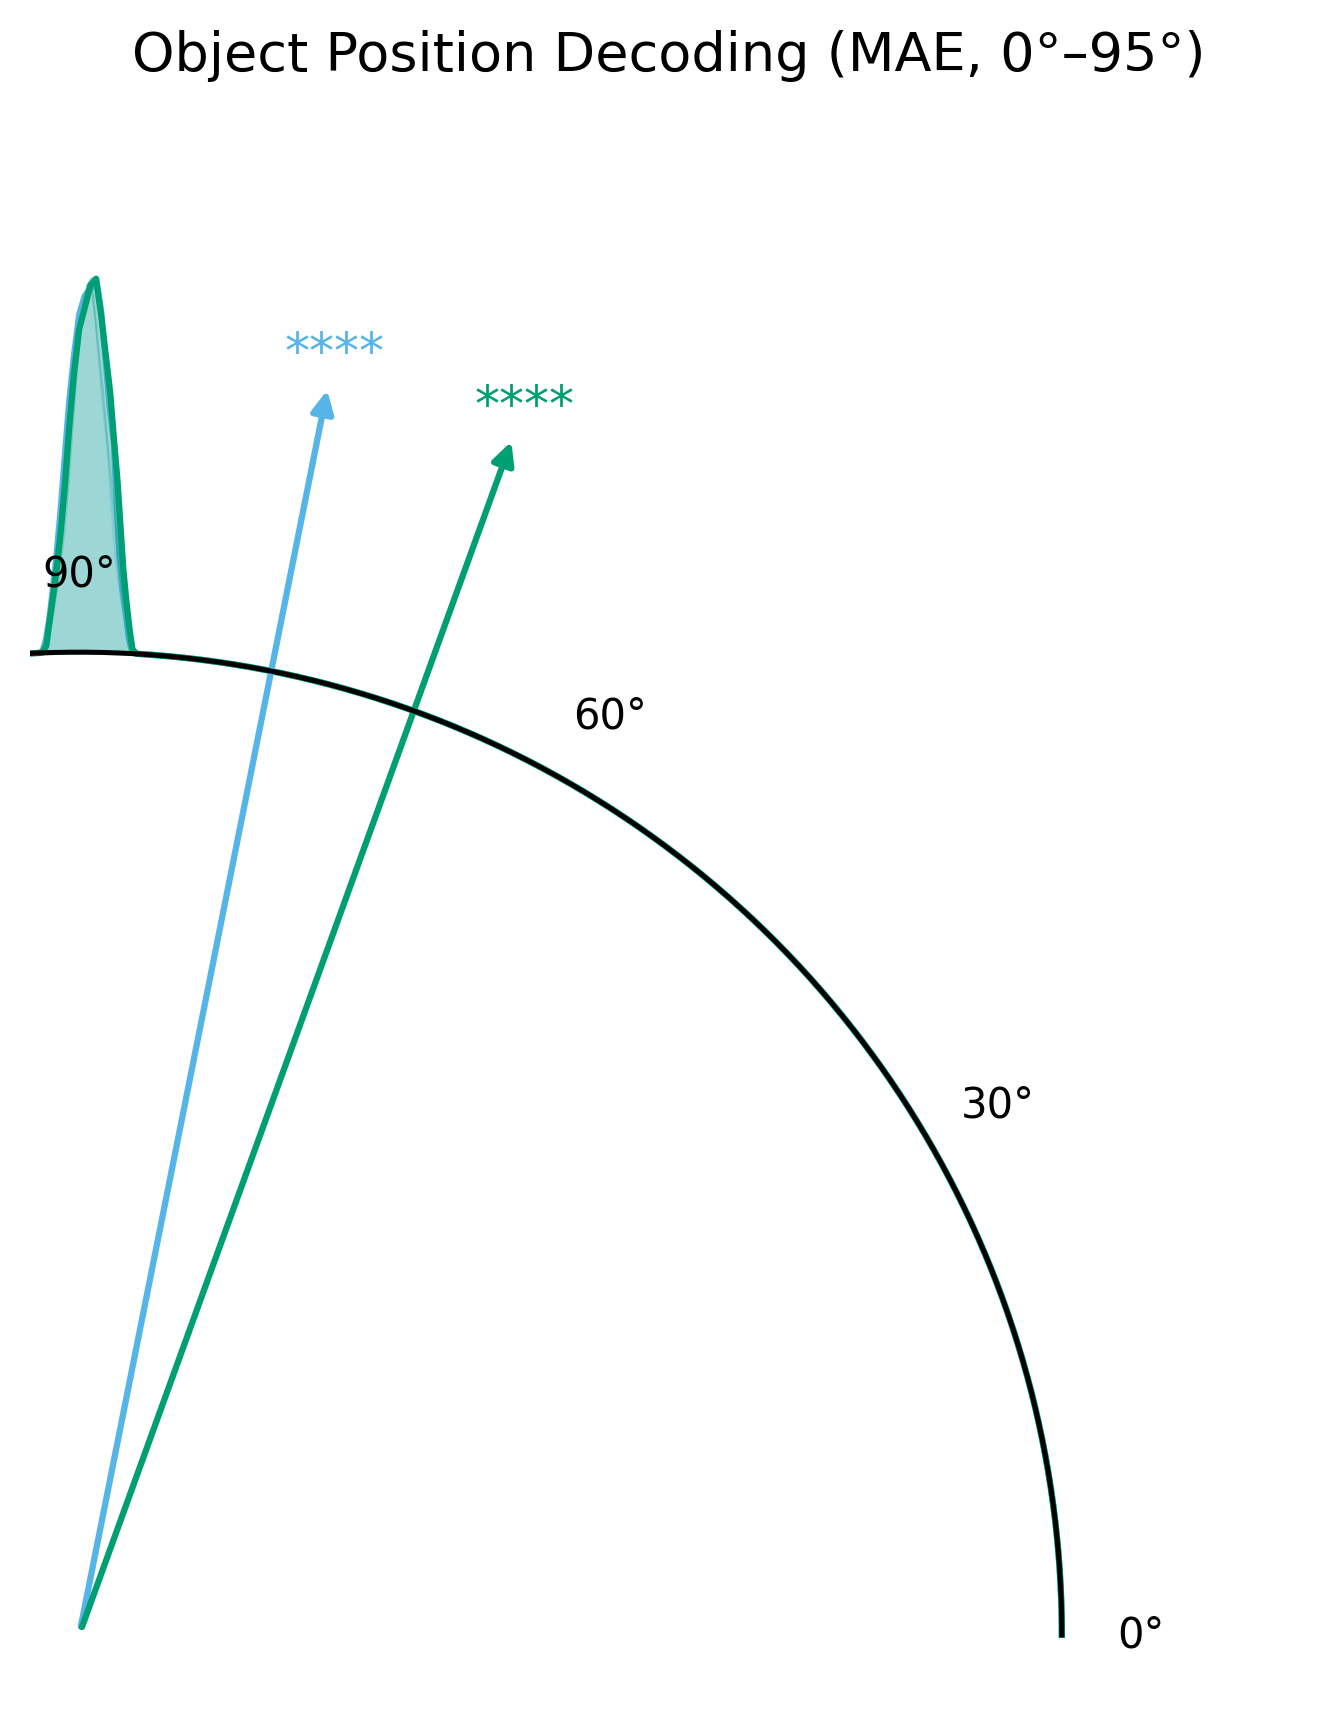

Figure saved → Figures/objpos_decoding_quartercircle_deg.png
                 Figures/objpos_decoding_quartercircle_deg.svg
                 Figures/objpos_decoding_quartercircle_deg.pdf


In [ ]:
import os, re, pickle, warnings, time
from pathlib import Path
from itertools import combinations
import sys
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from scipy.stats import binomtest
from statsmodels.stats.multitest import multipletests
from pathlib import PurePath
from scipy.stats import gaussian_kde
import jax.numpy as jnp
from jax import jit
def load_and_align(pkl_path, meta_df):
    with open(pkl_path, "rb") as fh:
        d = pickle.load(fh)
    X = d["penultimate"]
    if X.ndim > 2:
        X = X.reshape(X.shape[0], -1)
    names = [Path(n).stem for n in d["image_names"]]
    idx = [names.index(b) for b in meta_df["base"]]
    return X[idx].astype(np.float64)

def predict_angles(net, pkl_path, meta_df, y_target, categories):
    X = load_and_align(pkl_path, meta_df)
    pred_t = np.zeros_like(y_target, dtype=np.float64)
    for cat in categories:
        tr = meta_df["category_name"] != cat
        te = ~tr
        pca = PCA(n_components=50, random_state=42)
        Xtr = pca.fit_transform(X[tr])
        Xte = pca.transform(X[te])
        reg = LinearRegression().fit(Xtr, y_target[tr])
        pred_t[te] = reg.predict(Xte)
    return np.arctan2(pred_t[:, 1], pred_t[:, 0])

def circ_diff(a, b):
    return np.arctan2(np.sin(a - b), np.cos(a - b))

def perm_pvalue(empirical, null_samples):
    if null_samples is None or len(null_samples) == 0 or np.isnan(empirical):
        return np.nan
    return (np.sum(null_samples <= empirical) + 1) / (len(null_samples) + 1)

def p_to_stars(p):
    if np.isnan(p):  return ''
    if p < 1e-4:     return '****'
    if p < 1e-3:     return '***'
    if p < 1e-2:     return '**'
    if p < 5e-2:     return '*'
    return ''

# ───────────────────────── Quarter‑circle drawing ─────────────────────────
THETA_MAX_DEG = 95   # extend slightly beyond 90° to include left KDE tail
THETA_MAX     = np.deg2rad(THETA_MAX_DEG)

def _deg_label(ax, R, deg,zorder = 1):
    th = np.deg2rad(deg)
    ax.text(R*1.08*np.cos(th), R*1.08*np.sin(th), f'{deg}°',
            ha='center', va='center', fontsize=10, zorder=zorder)

def quartercircle_axes(ax, R=1.0, theta_max=THETA_MAX, zorder=1):
    """Draw only a quarter of a circle (0° → ~95°) with degree labels."""
    t = np.linspace(0, theta_max, 300)
    ax.plot(R*np.cos(t), R*np.sin(t), lw=1.2, color='black', zorder=zorder)

    # Degree labels around the arc
    for deg in (0, 30, 60, 90):
        _deg_label(ax, R, deg,zorder= zorder)
    # Add black quarter circle

    # Neat framing for the first quadrant
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(-R*0.05, R*1.25)
    ax.set_ylim(-R*0.05, R*1.55)
    ax.axis('off')

def draw_kde_bump(ax, samples, *,
                  R=1.0, height=0.35, n=400, color="black",
                  alpha_fill=0.22, lw=2.0, z=3, theta_max=THETA_MAX):
    """
    Draw a KDE "bump" outside the quarter arc.
    Samples are cropped to 1–99 percentiles to avoid extreme tails.
    Evaluated only on [0, theta_max] (default 95°).
    """
    samples = np.asarray(samples).ravel()
    if samples.size < 2 or not np.all(np.isfinite(samples)):
        return

    lo, hi = np.percentile(samples, [1, 99])
    samples = samples[(samples >= lo) & (samples <= hi)]
    if samples.size < 2:
        return

    try:
        kde = gaussian_kde(samples)
    except np.linalg.LinAlgError:
        if np.allclose(samples, samples[0]):
            theta = float(samples[0])
            theta = np.clip(theta, 0.0, theta_max)
            xb, yb = R*np.cos(theta), R*np.sin(theta)
            xd, yd = (R+height)*np.cos(theta), (R+height)*np.sin(theta)
            ax.plot([xb, xd], [yb, yd], color=color, lw=lw, zorder=z)
        return

    thetas = np.linspace(0.0, theta_max, n)  # evaluate only over the quarter
    dens = kde(thetas)
    if dens.max() == 0:
        return
    dens /= np.max(dens)

    f = height * dens
    xb, yb = R*np.cos(thetas),     R*np.sin(thetas)
    xd, yd = (R+f)*np.cos(thetas), (R+f)*np.sin(thetas)

    ax.fill_between(xb, yb, yd, color=color, alpha=alpha_fill, zorder=z)
    ax.plot(xd, yd, color=color, lw=lw, zorder=z+1)

# ───────────────────────── Config (unchanged) ─────────────────────────
plt.rcParams.update({"svg.fonttype": "none"})  # keep text editable in SVG

# Color codes: early = blue, late = green
PALETTE_EARLY = {'Perm': '#56B4E9', 'Obs': '#56B4E9'}
PALETTE_LATE  = {'Perm': '#009E73', 'Obs': '#009E73'}

FIG_DIR = Path(globals().get("FIG_DIR", "Figures")); FIG_DIR.mkdir(exist_ok=True)

# ───────────────────────── Data prep (unchanged) ─────────────────────────
meta = pd.read_csv('downloads/hvm_public_extended_meta.csv')
meta["base"] = meta["filename"].str.replace(r"\.\w+$", "", regex=True)

# keep only the 2,560 high-variation stimuli (skip first 640)
valid_idx = np.arange(640, len(meta))
meta = meta.iloc[valid_idx].reset_index(drop=True)

# centroid → polar angle (y, x)
pos = np.vstack((meta["centroid_y"].values, meta["centroid_x"].values)).T
pos = (pos - 128) / 256 * 8
true_angle = np.arctan2(pos[:, 1], pos[:, 0])  # note: (y, x) swap preserved
y_target = np.column_stack((np.cos(true_angle), np.sin(true_angle)))

categories   = meta["category_name"].unique()
cat_labels   = meta["category_name"].values
_cat_to_idx  = {c: np.flatnonzero(cat_labels == c) for c in categories}

# ───────────────────── Neural decoding (Early)
rate_even = np.load('downloads/Spike_count_even_sessions_ms_free.npy', allow_pickle=True)
rate_odd  = np.load('downloads/Spike_count_odd_sessions_ms_free.npy',  allow_pickle=True)
rate = ((rate_even + rate_odd) / 2.0)[valid_idx]  # align to meta

time_range_early = slice(5, 9)  # 50–90 ms
time_range_late = slice(10, 20)  # 100-200 ms
feats_early = rate[:, :, time_range_early].reshape(rate.shape[0], -1)
feats_late = rate[:, :, time_range_late].reshape(rate.shape[0], -1)

pred_target_early = np.zeros_like(y_target)
pred_target_late = np.zeros_like(y_target)
for cat in categories:
    tr = meta["category_name"] != cat
    te = ~tr

    # early period
    pca = PCA(n_components=50, random_state=42)
    Xtr_early = pca.fit_transform(feats_early[tr])
    Xte_early = pca.transform(feats_early[te])
    reg_early = LinearRegression().fit(Xtr_early, y_target[tr])
    pred_target_early[te] = reg_early.predict(Xte_early)

    # late period
    pca = PCA(n_components=50, random_state=42)
    Xtr_late = pca.fit_transform(feats_late[tr])
    Xte_late = pca.transform(feats_late[te])
    reg_late = LinearRegression().fit(Xtr_late, y_target[tr])
    pred_target_late[te] = reg_late.predict(Xte_late)

# ───────────────────── Compute MAE (unchanged) ─────────────────────
pred_ang_early = np.arctan2(pred_target_early[:, 1], pred_target_early[:, 0])
pred_ang_late = np.arctan2(pred_target_late[:, 1], pred_target_late[:, 0])

angle_diff_early = circ_diff(pred_ang_early, true_angle)
angle_diff_late = circ_diff(pred_ang_late, true_angle)

N_PERM = 10_000
mae_neural = {"Early": np.abs(angle_diff_early).mean(),"Late":  np.abs(angle_diff_late).mean()}
mae_perm_neural = {"Early": np.empty(N_PERM, dtype=np.float64),"Late": np.empty(N_PERM, dtype=np.float64)}

rng = np.random.default_rng(42)
for i in range(N_PERM):
    shuffled = true_angle.copy()
    for _, idxs in _cat_to_idx.items():
        shuffled[idxs] = rng.permutation(shuffled[idxs])
    diff_p_early = circ_diff(pred_ang_early, shuffled)
    diff_p_late = circ_diff(pred_ang_late, shuffled)
    mae_perm_neural["Early"][i] = np.abs(diff_p_early).mean()
    mae_perm_neural["Late"][i] = np.abs(diff_p_late).mean()

# ───────────────────── Stats (unchanged) ─────────────────────
p_early = perm_pvalue(mae_neural.get("Early", np.nan), mae_perm_neural.get("Early", np.array([])))
p_late = perm_pvalue(mae_neural.get("Late", np.nan), mae_perm_neural.get("Late", np.array([])))
# ───────────────────── Plot (quarter‑circle up to 95°) ─────────────────────
fig, ax = plt.subplots(1, 1, figsize=(7.0, 5.6), constrained_layout=True)


draw_kde_bump(ax, mae_perm_neural["Early"], R=1.0, height=0.38,
                color=PALETTE_EARLY["Perm"], alpha_fill=0.26, lw=1.5, z=4, theta_max=THETA_MAX)
draw_kde_bump(ax, mae_perm_neural["Late"], R=1.0, height=0.38,
                color=PALETTE_LATE["Perm"], alpha_fill=0.26, lw=1.5, z=5, theta_max=THETA_MAX)
# Observed MAE rays — clip angle to 95° so arrows stay inside the panel
eps = np.deg2rad(0.25)
thN = np.clip(mae_neural["Early"], 0.0, THETA_MAX - eps)
ax.annotate("", xy=((1.0 + 0.30) * np.cos(thN), (1.0 + 0.30) * np.sin(thN)),
            xytext=(0, 0),
            arrowprops=dict(arrowstyle='-|>', lw=1.5, color=PALETTE_EARLY["Obs"]),
            zorder=6)
s = p_to_stars(p_early)
if s:
    ax.text((1.0 + 0.33) * np.cos(thN), (1.0 + 0.33) * np.sin(thN),
            s, ha='center', va='center', fontsize=12, color=PALETTE_EARLY["Obs"], zorder=7)

thN = np.clip(mae_neural["Late"], 0.0, THETA_MAX - eps)
ax.annotate("", xy=((1.0 + 0.30) * np.cos(thN), (1.0 + 0.30) * np.sin(thN)),
            xytext=(0, 0),
            arrowprops=dict(arrowstyle='-|>', lw=1.5, color=PALETTE_LATE["Obs"]),
            zorder=6)
s = p_to_stars(p_late)
if s:
    ax.text((1.0 + 0.33) * np.cos(thN), (1.0 + 0.33) * np.sin(thN),
            s, ha='center', va='center', fontsize=12, color=PALETTE_LATE["Obs"], zorder=7)

quartercircle_axes(ax, R=1.0, theta_max=THETA_MAX, zorder=7)
ax.set_title("Object Position Decoding (MAE, 0°–95°)", pad=10, fontsize=13)

out_png = FIG_DIR / "objpos_decoding_quartercircle_deg.png"
out_svg = FIG_DIR / "objpos_decoding_quartercircle_deg.svg"
out_pdf = FIG_DIR / "objpos_decoding_quartercircle_deg.pdf"
fig.savefig(out_png, dpi=300, bbox_inches="tight")
fig.savefig(out_svg, bbox_inches="tight")
fig.savefig(out_pdf, bbox_inches="tight")
plt.show()
print(f"Figure saved → {out_png}\n                 {out_svg}\n                 {out_pdf}")

# Decode category

Pairwise category decoding — Neural (50–90 ms)…
Pairwise category decoding — Neural (100–200 ms)…
Saved:
  Figures/pairwise_combined_upper_early_lower_late_neural.png
  Figures/pairwise_combined_upper_early_lower_late_neural.svg
  Figures/pairwise_combined_upper_early_lower_late_neural.pdf


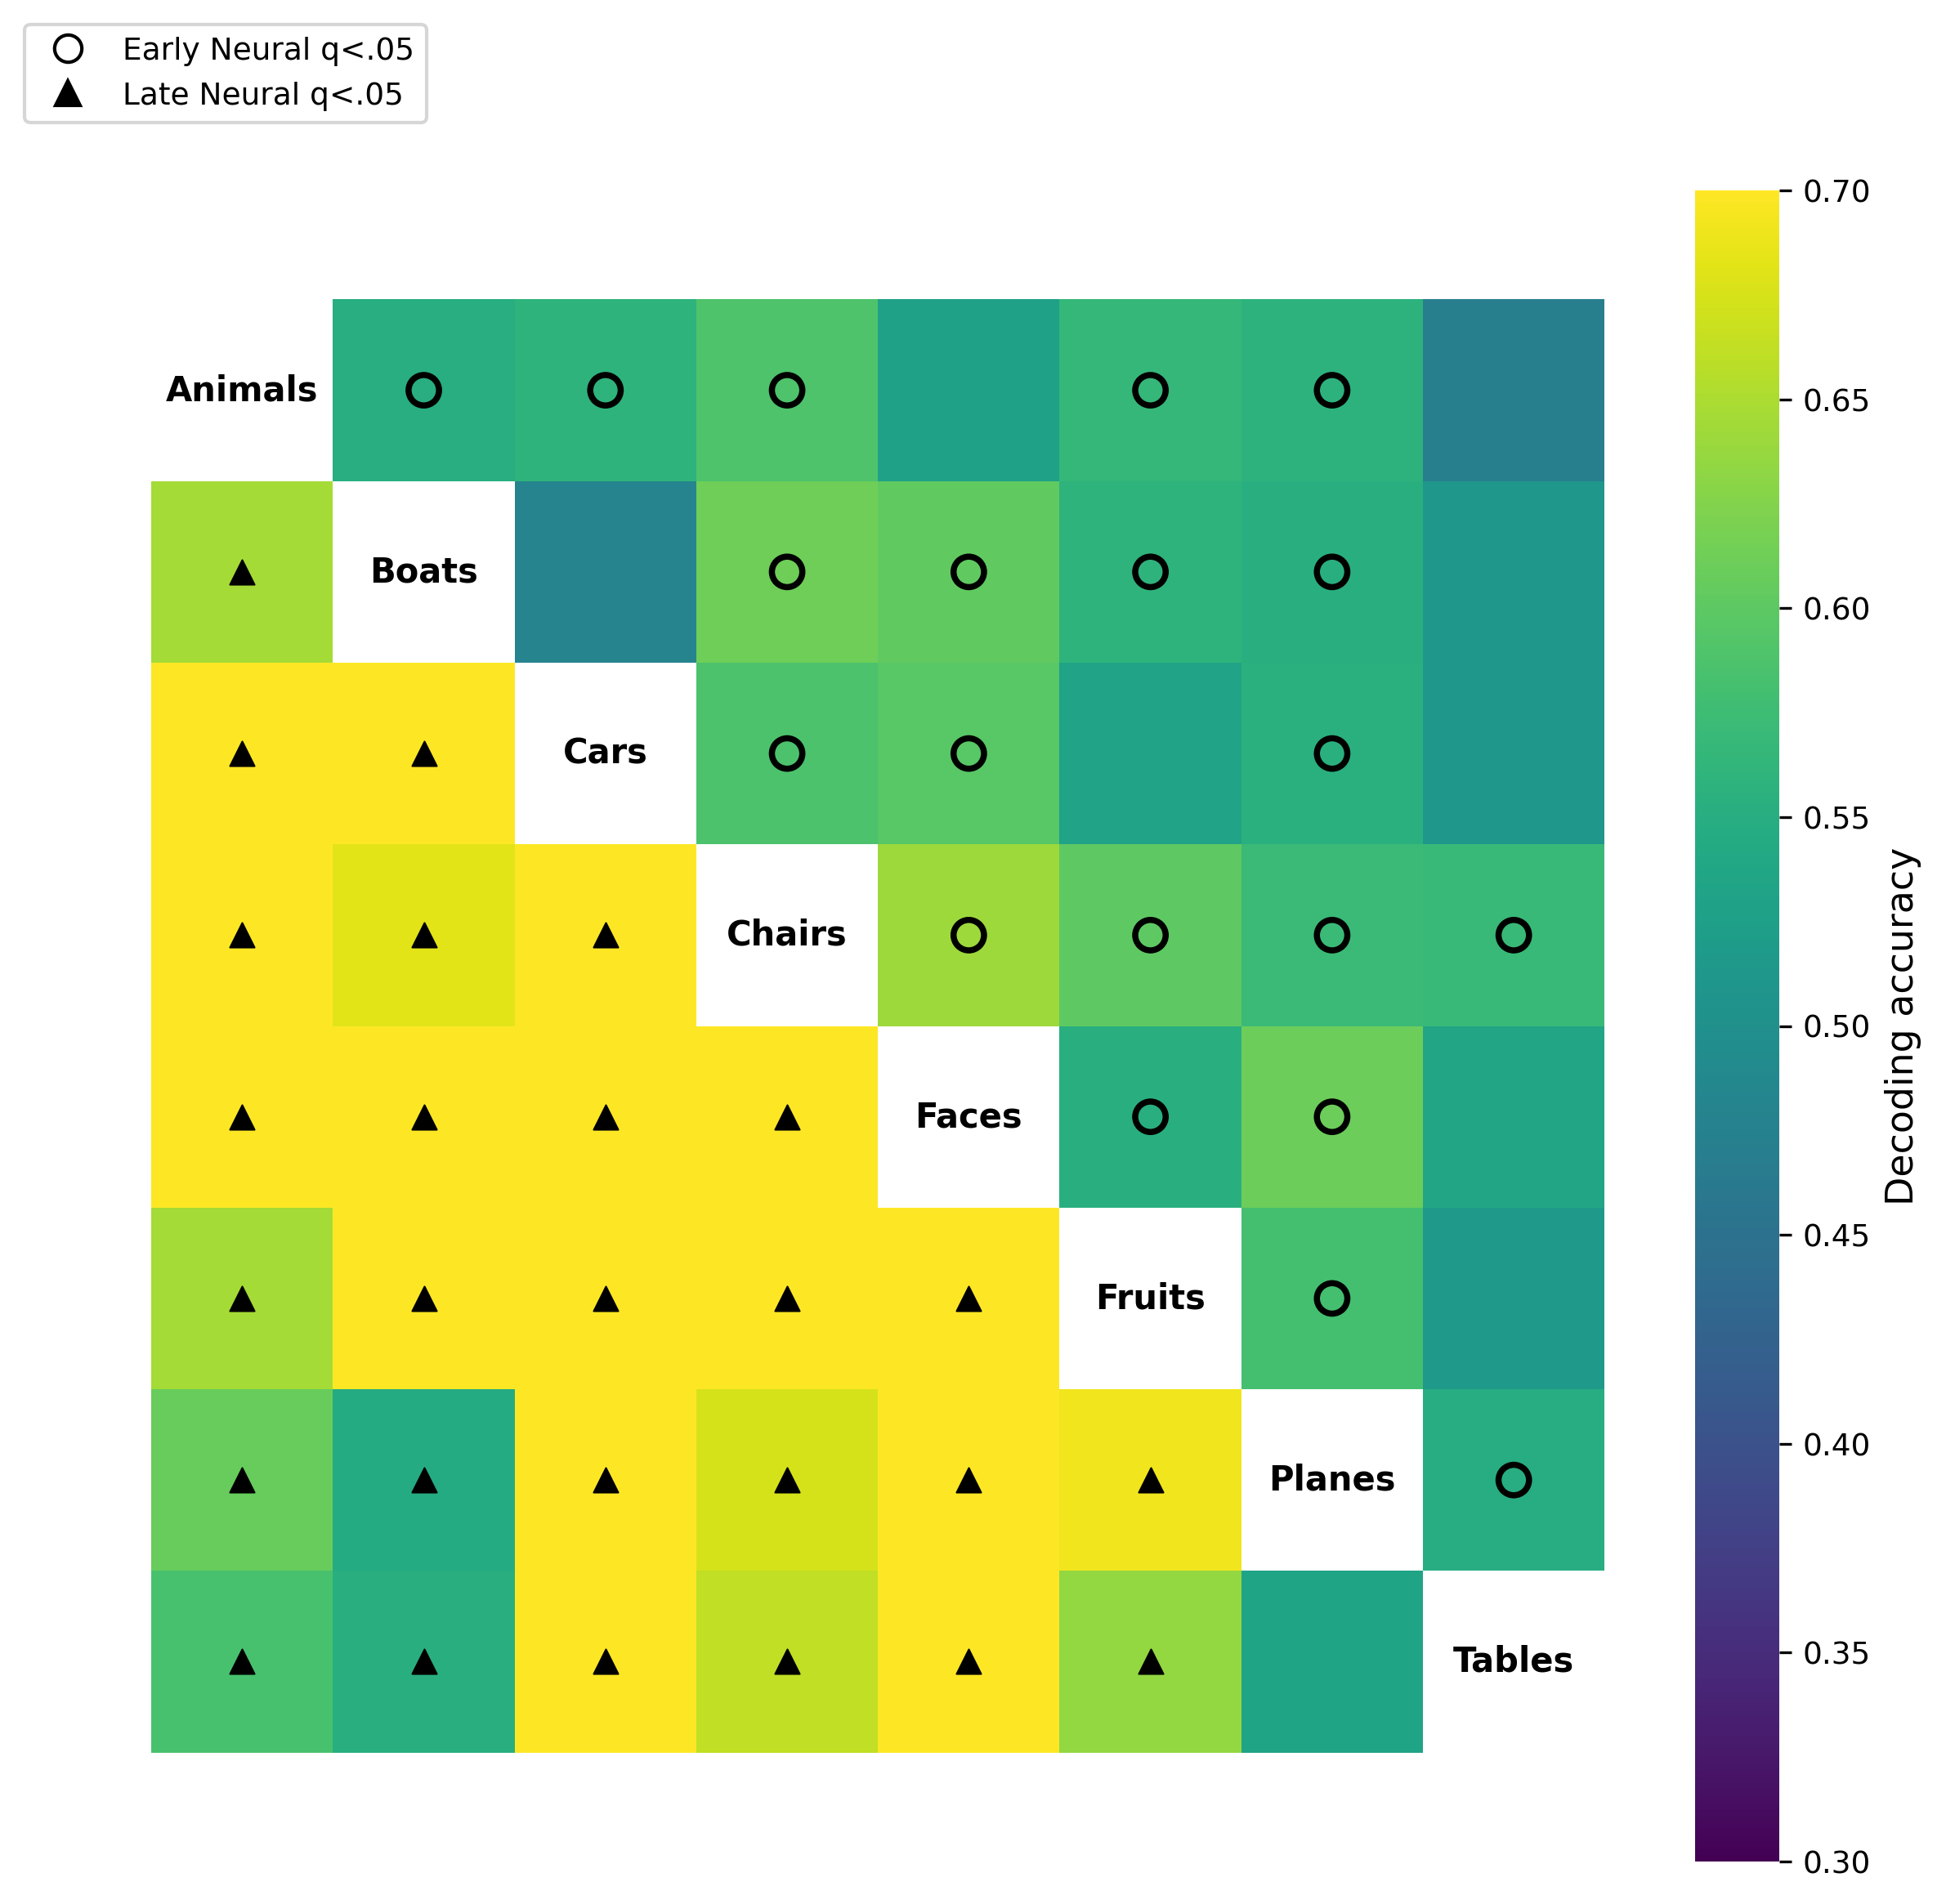

In [ ]:
# ========================== Pairwise Category Decoding ========================
import re, os
from pathlib import Path, PurePath
from itertools import combinations
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from scipy.stats import binomtest
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns

FIG_DIR = Path("Figures"); FIG_DIR.mkdir(exist_ok=True, parents=True)

# ---------- Load & filter metadata ----------
meta = pd.read_csv('downloads/hvm_public_extended_meta.csv')
meta["base"] = meta["filename"].str.replace(r"\.\w+$", "", regex=True)
valid_idx = np.arange(640, len(meta))
meta = meta.iloc[valid_idx].reset_index(drop=True)

# ---------- Helpers ----------
def flatten(data, t_idx):
    data = data[:, :, t_idx]
    return data.reshape(data.shape[0], -1)

def decode_pair(cat1, cat2, X_flat, labels, obj_names):
    """
    Pairwise decoding with leave‑one‑object‑per‑category out.
    Aggregates per‑trial probabilities across all (o1,o0) test folds.
    """
    mask_pair  = (labels == cat1) | (labels == cat2)
    X_pair_all = X_flat[mask_pair]
    y_pair_all = (labels[mask_pair] == cat1).astype(int)
    obj_pair   = obj_names[mask_pair]

    # PCA fitted outside pair images to avoid leakage
    train_mask_for_pca = (labels != cat1) & (labels != cat2)
    pca_global = PCA(n_components=50, random_state=42).fit(X_flat[train_mask_for_pca])

    n_pair = len(X_pair_all)
    sum_pos  = np.zeros(n_pair, dtype=float)
    sum_corr = np.zeros(n_pair, dtype=float)
    counts   = np.zeros(n_pair, dtype=int)

    objs1 = np.unique(obj_pair[y_pair_all == 1])
    objs0 = np.unique(obj_pair[y_pair_all == 0])

    clf = LogisticRegression(max_iter=500, solver="lbfgs", random_state=42)

    for o1 in objs1:
        for o0 in objs0:
            te_mask = (obj_pair == o1) | (obj_pair == o0)
            tr_mask = ~te_mask
            if tr_mask.sum() == 0 or te_mask.sum() == 0:
                continue

            X_tr = pca_global.transform(X_pair_all[tr_mask])
            X_te = pca_global.transform(X_pair_all[te_mask])
            y_tr = y_pair_all[tr_mask]
            y_te = y_pair_all[te_mask]

            clf.fit(X_tr, y_tr)
            proba_pos = clf.predict_proba(X_te)[:, 1]  # P(class==cat1)
            proba_corr = np.where(y_te == 1, proba_pos, 1 - proba_pos)

            idx_te_within_pair = np.flatnonzero(te_mask)
            sum_pos[idx_te_within_pair]  += proba_pos
            sum_corr[idx_te_within_pair] += proba_corr
            counts[idx_te_within_pair]   += 1

    valid = counts > 0
    if valid.sum() == 0:
        global_probs = np.full(len(labels), np.nan)
        global_probs[mask_pair] = np.nan
        return (cat1, cat2, np.nan, np.nan, global_probs)

    mean_pos  = np.full(n_pair, np.nan);  mean_pos[valid]  = sum_pos[valid] / counts[valid]
    mean_corr = np.full(n_pair, np.nan);  mean_corr[valid] = sum_corr[valid] / counts[valid]

    preds = (mean_pos[valid] >= 0.5).astype(int)
    acc   = (preds == y_pair_all[valid]).mean()
    k     = int(acc * valid.sum())
    pval  = binomtest(k, n=valid.sum(), p=0.5, alternative="greater").pvalue

    global_probs = np.full(len(labels), np.nan)
    global_probs[mask_pair] = mean_corr
    return (cat1, cat2, acc, pval, global_probs)

def parallel_decoding(X_flat, labels_cat, objects, cat_pairs):
    """Decode every category pair in parallel; return matrices and per-trial means."""
    results = Parallel(n_jobs=-1, backend="loky")(
        delayed(decode_pair)(c1, c2, X_flat, labels_cat, objects)
        for c1, c2 in cat_pairs
    )

    acc  = {(c1, c2): a for c1, c2, a, _, _ in results}
    pval = {(c1, c2): p for c1, c2, _, p, _ in results}
    probs= {(c1, c2): pr for c1, c2, _, _, pr in results}

    prob_matrix = np.stack([probs[pair] for pair in cat_pairs], axis=1)
    mean_trial  = np.nanmean(prob_matrix, axis=1)

    # FDR over all pairs
    p_vals = np.array([pval[pair] for pair in cat_pairs])
    _, q, _, _ = multipletests(p_vals, method="fdr_bh")
    qdict = {pair: qv for pair, qv in zip(cat_pairs, q)}

    categories = np.unique(labels_cat)
    nC = len(categories)
    A  = np.full((nC, nC), np.nan)
    S  = np.zeros((nC, nC), bool)
    for (c1, c2) in cat_pairs:
        i = np.where(categories == c1)[0][0]
        j = np.where(categories == c2)[0][0]
        if i < j:
            A[i, j] = acc[(c1, c2)]
            S[i, j] = qdict[(c1, c2)] < 0.05
    return A, S, probs, mean_trial

def plot_combined_upper_early_lower_late(A_neu_early, S_neu_early, A_neu_late, S_neu_late, categories,
                                         vmin=.3, vmax=.7, cmap="viridis"):
    """
    Build one matrix where:
      - Upper triangle (ij): Late Neural accuracies
      - Diagonal: blank (with category names written inside)
    Significance:
      - Early Neural: open white circle '◦' on upper cells with q<.05
      - Late Neural   : filled triangle '▲' on lower cells with q<.05
    """
    nC = len(categories)
    C   = np.full((nC, nC), np.nan)
    SigEarly= np.zeros((nC, nC), bool)
    SigLate= np.zeros((nC, nC), bool)

    # Upper: Early Neural (already stored on upper in A_neu_early)
    if A_neu_early is not None:
        upper = ~np.isnan(A_neu_early)
        C[upper] = A_neu_early[upper]
        SigEarly[upper] = S_neu_early[upper]

    # Lower: Late Neural — our A_neu_late is also upper-only, so mirror into lower
    if A_neu_late is not None:
        upper = ~np.isnan(A_neu_late)
        # write to the symmetric lower cells
        C.T[upper] = A_neu_late[upper]
        SigLate.T[upper] = S_neu_late[upper]


    # Heatmap without ticks; diagonal left NaN for text overlay
    fig, ax = plt.subplots(figsize=(8.4, 7.8))
    mask = np.isnan(C)
    hm = sns.heatmap(C, vmin=vmin, vmax=vmax, cmap=cmap, mask=mask,
                     cbar=True, square=True, ax=ax,
                     xticklabels=False, yticklabels=False,
                     cbar_kws={"label": "Decoding accuracy"})

    # Diagonal category names
    for i, cat in enumerate(categories):
        ax.text(i + 0.5, i + 0.5, str(cat),
                ha="center", va="center", fontsize=10, fontweight="bold",
                color="black", rotation=0)

    # Significance overlays
    # Early Neural (upper): open white circles
    for i in range(nC):
        for j in range(i+1, nC):
            if SigEarly[i, j]:
                ax.scatter(j + 0.5, i + 0.5, s=80,
                           facecolors="none", edgecolors="black", linewidths=1.8)

    # Late Neural (lower): filled triangles
    for i in range(1, nC):
        for j in range(0, i):
            if SigLate[i, j]:
                ax.scatter(j + 0.5, i + 0.5, s=52, marker="^",
                           facecolors="black", edgecolors="black", linewidths=0.5)


    # Custom legend
    from matplotlib.lines import Line2D
    legend_elems = [
        Line2D([0], [0], marker='o', linestyle='None', markersize=8,
               markerfacecolor='none', markeredgecolor='black', label='Early Neural q<.05'),
        Line2D([0], [0], marker='^', linestyle='None', markersize=7,
               markerfacecolor='black', markeredgecolor='black', label='Late Neural q<.05'),
    ]
    ax.legend(handles=legend_elems, loc='upper right', bbox_to_anchor=(.2, 1.2))
    plt.tight_layout()
    out_svg = FIG_DIR / "pairwise_combined_upper_early_lower_late_neural.svg"
    out_png = FIG_DIR / "pairwise_combined_upper_early_lower_late_neural.png"
    out_pdf = FIG_DIR / "pairwise_combined_upper_early_lower_late_neural.pdf"
    fig.savefig(out_svg); fig.savefig(out_png, dpi=300); fig.savefig(out_pdf)
    print(f"Saved:\n  {out_png}\n  {out_svg}\n  {out_pdf}")
    plt.show()


# ------------------------------ Run pairwise decoding -------------------------
meta_df = meta.copy()
labels_cat = meta_df["category_name"].values
objects    = meta_df["object_name"].values
categories_unique = np.unique(labels_cat)
cat_pairs  = list(combinations(categories_unique, 2))

A_neu_early = S_neu_early = A_neu_late = S_neu_late = None

# Neural early features

print("Pairwise category decoding — Neural (50–90 ms)…")
rate_even = np.load('downloads/Spike_count_even_sessions_ms_free.npy', allow_pickle=True)
rate_odd  = np.load('downloads/Spike_count_odd_sessions_ms_free.npy',  allow_pickle=True)
even_raw, odd_raw = rate_even, rate_odd
early_idx = slice(5, 9)  # 50–90 ms
X_early = flatten((even_raw[valid_idx] + odd_raw[valid_idx]) / 2, early_idx)
A_neu_early, S_neu_early, _, _ = parallel_decoding(X_early, labels_cat, objects, cat_pairs)

# Neural late features
print("Pairwise category decoding — Neural (100–200 ms)…")
late_idx = slice(10, 20) # 100-200 ms
X_late = flatten((even_raw[valid_idx] + odd_raw[valid_idx]) / 2, late_idx)
A_neu_late, S_neu_late, _, _ = parallel_decoding(X_late, labels_cat, objects, cat_pairs)



# Plot the combined heatmap
plot_combined_upper_early_lower_late(A_neu_early, S_neu_early, A_neu_late, S_neu_late, categories_unique)

# RSA with DNNs

downloads/hvm_public_extended_meta.csv already exists.
downloads/deepNetFeatures.zip already exists.
downloads/Spike_count_even_sessions_ms_free.npy already exists.
downloads/Spike_count_odd_sessions_ms_free.npy already exists.


/tmp/ipython-input-2019674382.py:145: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  feat[m["net"]][m["flav"]] = pickle.load(fh)
/tmp/ipython-input-2019674382.py:257: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(xi, yi, s=24, marker=MARKERS[k], c=col, alpha=.7, edgecolors='none')
/tmp/ipython-input-2019674382.py:257: UserWarning: You passed a edgecolor/ed

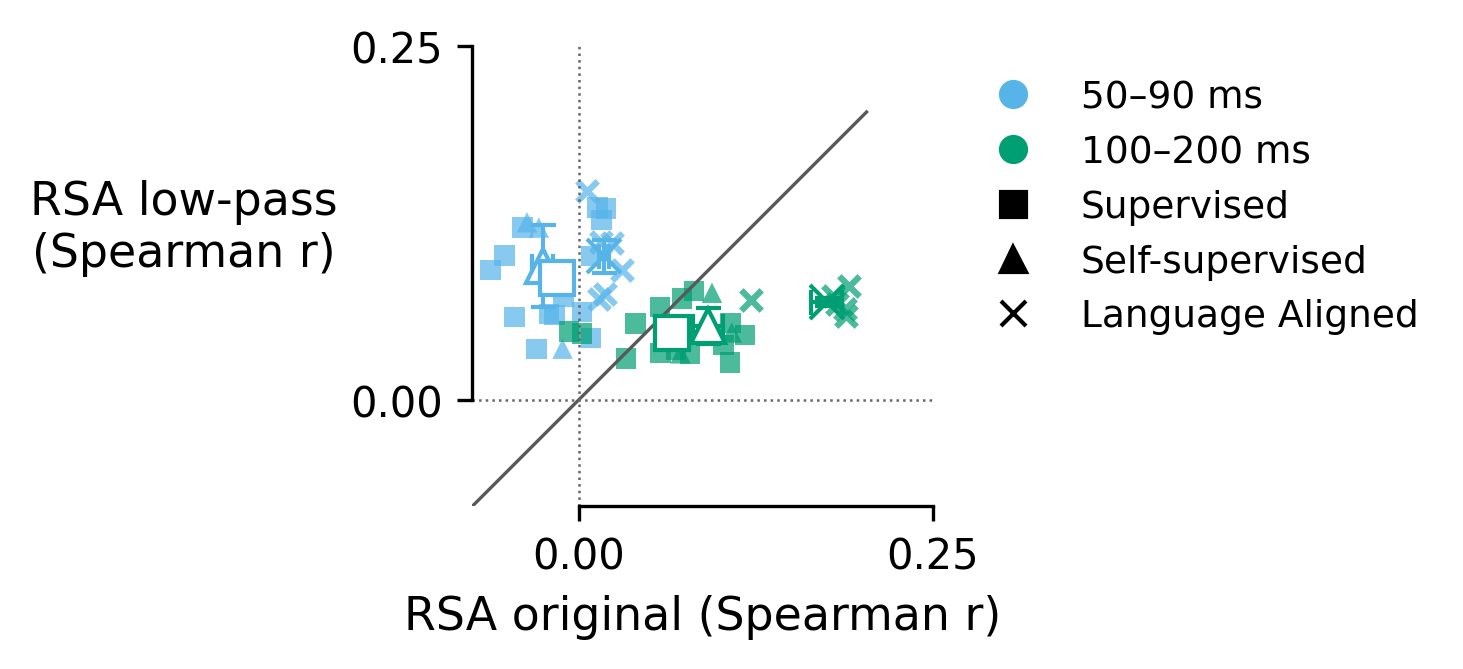

,Window,Condition,Mean,SEM,Direction,p,q,Sig
0,50–90 ms,Original,-0.008,0.006,,0.9071,0.9071,
1,50–90 ms,Low-pass,0.091,0.007,,0.0001,0.0001,***
2,50–90 ms,Orig – LP,-0.099,NaN,LP > Orig,0.0001,0.0001,***
3,100–200 ms,Original,0.098,0.012,,0.0001,0.0001,***
4,100–200 ms,Low-pass,0.053,0.004,,0.0001,0.0001,***
5,100–200 ms,Orig – LP,0.044,NaN,Orig > LP,0.0009,0.0011,**


,Window,GroupA,GroupB,Direction,p,q,Sig
0,50–90 ms,Language Aligned,Supervised,Language Aligned > Supervised,0.0412,0.0824,
1,50–90 ms,Language Aligned,Self-supervised,Language Aligned > Self-supervised,0.0818,0.1227,
2,50–90 ms,Supervised,Self-supervised,Supervised > Self-supervised,0.9367,0.9367,
3,100–200 ms,Language Aligned,Supervised,Language Aligned > Supervised,0.0001,0.0006,***
4,100–200 ms,Language Aligned,Self-supervised,Language Aligned > Self-supervised,0.0120,0.0360,*
5,100–200 ms,Supervised,Self-supervised,Self-supervised > Supervised,0.2520,0.3024,


In [3]:
"""
RSA with DNNs processing original or blurry images — ms_free dataset
This script generates the figure comparing vlPFC representational geometry
in the early and late time periods with DNN representations of the original
images or images blurred to simulate magnocellular-biased information.

Changes vs. original ms_free script:
- Removed round-robin batching. We create a SINGLE, NON-OVERLAPPING, RANDOM
  partition of the (network ∩ metadata) common stimuli into 16-image batches.
- Statistical comparison Original vs Low-pass is NOW PAIRED:
  one-sample sign-flip permutation on within-network differences (Orig − LP).
- No MDS code.
"""

import warnings
from pathlib import Path
from collections import defaultdict
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import rankdata
from statsmodels.stats.multitest import multipletests
from scipy.spatial.distance import pdist
from matplotlib import colors as mcolors  # kept if you add styling later
import re
import pickle
from tqdm import tqdm
import os
import sys

# ──────────────────────────────────────────────────────────────────────
# 0. Environment detection
# ──────────────────────────────────────────────────────────────────────
IN_COLAB = False
IN_KAGGLE = False
try:
    if 'google.colab' in str(get_ipython()):
        IN_COLAB = True
except NameError:
    pass
if not IN_COLAB:
    if os.environ.get('KAGGLE_KERNEL_RUN_TYPE', 'Localhost') == 'Interactive':
        IN_KAGGLE = True

# Determine the path to the repository based on the environment
if IN_COLAB:
    path_to_repo = '/content/Dynamics-of-Visual-Representations-in-a-Macaque-Ventrolateral-Prefrontal-Cortex'
elif IN_KAGGLE:
    path_to_repo = '/kaggle/working/Dynamics-of-Visual-Representations-in-a-Macaque-Ventrolateral-Prefrontal-Cortex'
else:
    path_to_repo = '.'

# Only clone if not already present
if not os.path.exists(os.path.join(path_to_repo, 'utils')):
    os.system("git clone https://github.com/jobellet/Dynamics-of-Visual-Representations-in-a-Macaque-Ventrolateral-Prefrontal-Cortex.git " + path_to_repo)

sys.path.append(path_to_repo)
sys.path.append(os.path.join(path_to_repo, 'utils'))

from utils.extract_and_download_data import download_files, unzip
from utils.analysis_utils import (
    spearman_corr_ranked,
    training_kind,
    perm_signflip_onesample,      # used for one-sample tests and paired diff via sign-flip
    perm_diff_independent,        # used only for training-group comparisons
    condensed
)
from utils.plotting_utils import q_to_stars

jax.config.update("jax_enable_x64", True)
warnings.filterwarnings("ignore", category=FutureWarning)

rng_global = np.random.default_rng(42)

BATCH_SIZE   = 16
TIME_WINDOWS = {                       # indices on the >0 ms axis
    "50–90 ms":   slice(5,  9),        # 50–90 ms
    "100–200 ms": slice(10, 20)        # 105–195 ms
}
PALETTE = {                            # Okabe–Ito, red-green safe
    "50–90 ms":   "#56B4E9",
    "100–200 ms": "#009E73"
}
MARKERS = {"Supervised": "s", "Self-supervised": "^", "Language Aligned": "x"}
N_PERM  = 10_000

FIGURES_DIR    = Path("Figures")
STATISTICS_DIR = Path("Statistics")
FIGURES_DIR.mkdir(exist_ok=True)
STATISTICS_DIR.mkdir(exist_ok=True)

plt.rcParams.update({
    "figure.dpi":         300,
    "axes.spines.top":    False,
    "axes.spines.right":  False,
    "axes.labelsize":     11,
    "xtick.labelsize":    10,
    "ytick.labelsize":    10,
})

# ──────────────────────────────────────────────────────────────────────
# 1. Ensure data present (first run only)
# ──────────────────────────────────────────────────────────────────────
# If your environment defines `private_link`, this will fetch the files.
# Otherwise comment out the next two lines if files already exist locally.
download_files(path_to_repo, [
    "deepNetFeatures.zip",
    "hvm_public_extended_meta.csv",
    "Spike_count_even_sessions_ms_free.npy",
    "Spike_count_odd_sessions_ms_free.npy",
], private_link=private_link)

unzip(Path("downloads") / "deepNetFeatures.zip", "deepNetFeatures")

# ──────────────────────────────────────────────────────────────────────
# 2. Load metadata & ms_free spike counts (averaged odd/even here)
# ──────────────────────────────────────────────────────────────────────
meta = pd.read_csv(Path("downloads") / "hvm_public_extended_meta.csv")
spike_counts_even = np.load(Path("downloads") / "Spike_count_even_sessions_ms_free.npy")
spike_counts_odd  = np.load(Path("downloads") / "Spike_count_odd_sessions_ms_free.npy")

spike_counts  = 0.5 * (spike_counts_even + spike_counts_odd)
n_stim        = spike_counts.shape[0]
stim_base     = meta['image_id'].str.strip().tolist()

def slice_flat(arr, slc):
    """Flatten (channels × time-bins-in-window) per stimulus."""
    return arr[:, :, slc].reshape(n_stim, -1)

neural = {lbl: slice_flat(spike_counts, sli) for lbl, sli in TIME_WINDOWS.items()}

# ──────────────────────────────────────────────────────────────────────
# 3. Load DNN features
# ──────────────────────────────────────────────────────────────────────
feat_dir = Path("deepNetFeatures")
patt     = re.compile(r"^(?P<net>.*)_features_high_variation_(?P<flav>original|lowpass)\.pkl$")
feat = defaultdict(dict)
for pkl in feat_dir.glob("*.pkl"):
    m = patt.match(pkl.name)
    if m:
        with open(pkl, "rb") as fh:
            feat[m["net"]][m["flav"]] = pickle.load(fh)

# keep only nets that have both original and lowpass variants
feat  = {k: v for k, v in feat.items() if set(v) == {"original", "lowpass"}}
nets  = sorted(feat)
train_type = {n: training_kind(n) for n in nets}

# ──────────────────────────────────────────────────────────────────────
# 4. Helper: single random, non-overlapping partition into 16s
# ──────────────────────────────────────────────────────────────────────
def make_batches_single_partition(n_items, batch_size, rng):
    """
    Returns a list of arrays of length `batch_size` that form a single,
    non-overlapping partition of as many items as fit. Leftovers are dropped.
    """
    perm   = rng.permutation(n_items)
    n_full = (n_items // batch_size) * batch_size
    perm   = perm[:n_full]
    return [perm[i:i+batch_size] for i in range(0, n_full, batch_size)]

# ──────────────────────────────────────────────────────────────────────
# 5. RSA computation (single-partition 16-stim batches, paired tests)
# ──────────────────────────────────────────────────────────────────────
rsa = {lbl: {} for lbl in TIME_WINDOWS}

for net in nets:
    f_o = feat[net]["original"]["penultimate"]
    f_l = feat[net]["lowpass"]["penultimate"]
    if f_o.ndim > 2: f_o = f_o.reshape(f_o.shape[0], -1)
    if f_l.ndim > 2: f_l = f_l.reshape(f_l.shape[0], -1)

    names_o = [Path(x).stem for x in feat[net]["original"]["image_names"]]
    names_l = [Path(x).stem for x in feat[net]["lowpass"]["image_names"]]
    common  = sorted(set(names_o) & set(names_l) & set(stim_base))

    if len(common) < BATCH_SIZE:
        warnings.warn(f"{net}: skipped (only {len(common)} common stimuli).")
        continue

    idx_o = np.array([names_o.index(s)   for s in common])
    idx_l = np.array([names_l.index(s)   for s in common])
    idx_n = np.array([stim_base.index(s) for s in common])

    # SINGLE random non-overlapping partition (seeded for reproducibility)
    batches = make_batches_single_partition(len(common), BATCH_SIZE, rng_global)

    accum = {lbl: {"o": [], "l": []} for lbl in TIME_WINDOWS}
    for b in batches:
        # condensed distances within the 16-sized batch; rank before correlation
        r_o = rankdata(condensed(f_o[idx_o[b]]))
        r_l = rankdata(condensed(f_l[idx_l[b]]))
        for lbl, neu_mat in neural.items():
            r_n = rankdata(condensed(neu_mat[idx_n[b]]))
            accum[lbl]["o"].append(spearman_corr_ranked(r_n, r_o))
            accum[lbl]["l"].append(spearman_corr_ranked(r_n, r_l))

    # average across batches → one value per (net × window × condition)
    for lbl in TIME_WINDOWS:
        mu_o = float(np.mean(accum[lbl]["o"]))
        se_o = float(np.std(accum[lbl]["o"], ddof=1) / np.sqrt(len(accum[lbl]["o"])))
        mu_l = float(np.mean(accum[lbl]["l"]))
        se_l = float(np.std(accum[lbl]["l"], ddof=1) / np.sqrt(len(accum[lbl]["l"])))
        rsa[lbl][net] = (mu_o, se_o, mu_l, se_l)

# ──────────────────────────────────────────────────────────────────────
# 6. Gather per-window vectors & paired stats (Orig vs Low-pass)
# ──────────────────────────────────────────────────────────────────────
vals, one_p, pair_p = {}, {}, {}
for lbl in TIME_WINDOWS:
    mu_o = np.array([rsa[lbl][n][0] for n in nets if n in rsa[lbl]])
    se_o = np.array([rsa[lbl][n][1] for n in nets if n in rsa[lbl]])
    mu_l = np.array([rsa[lbl][n][2] for n in nets if n in rsa[lbl]])
    se_l = np.array([rsa[lbl][n][3] for n in nets if n in rsa[lbl]])
    kept = [n for n in nets if n in rsa[lbl]]
    vals[lbl] = (mu_o, se_o, mu_l, se_l, kept)

    # one-sample tests vs 0 (per condition) across networks
    _, _, p_o   = perm_signflip_onesample(mu_o, N_PERM, greater=True)
    _, _, p_l   = perm_signflip_onesample(mu_l, N_PERM, greater=True)
    one_p[lbl]  = (p_o, p_l)

    # ★ paired test: within-network difference (Orig − Low-pass), two-sided
    diff        = mu_o - mu_l
    _, _, p_pr  = perm_signflip_onesample(diff, N_PERM, greater=False)
    pair_p[lbl] = p_pr

# FDR across all p’s (two windows × [Orig, LP, paired])
raw_p = [*sum(one_p.values(), ()), *pair_p.values()]
_, q_all, *_ = multipletests(raw_p, method="fdr_bh")
q_iter = iter(q_all)
q_one, q_pair = {}, {}
for lbl in TIME_WINDOWS:        # Orig, LP
    q_one[lbl] = (next(q_iter), next(q_iter))
for lbl in TIME_WINDOWS:        # paired
    q_pair[lbl] = next(q_iter)

# ──────────────────────────────────────────────────────────────────────
# 7. Scatter plot (RSA original vs low-pass), per window
# ──────────────────────────────────────────────────────────────────────
def group_stats(values, types):
    df = pd.DataFrame({'val': values, 'kind': types})
    return df.groupby('kind')['val'].mean(), df.groupby('kind')['val'].sem(ddof=1)

fig, ax = plt.subplots(figsize=(5, 5))
ax.set_aspect('equal')

for lbl, (xo, _, xl, _, kept) in vals.items():
    col   = PALETTE[lbl]
    kinds = [training_kind(n) for n in kept]

    # 1) individual nets
    for xi, yi, k in zip(xo, xl, kinds):
        ax.scatter(xi, yi, s=24, marker=MARKERS[k], c=col, alpha=.7, edgecolors='none')

    # 2) group means ± SEM
    μx, σx = group_stats(xo, kinds)
    μy, σy = group_stats(xl, kinds)
    for k in μx.index:
        ax.errorbar(μx[k], μy[k], xerr=σx[k], yerr=σy[k],
                    fmt=MARKERS[k], mfc='white', mec=col,
                    ecolor=col, elinewidth=.95, capsize=3, zorder=4, ms=8)

lims = np.array([ax.get_xlim(), ax.get_ylim()]).flatten()
lims = lims.min(), lims.max()
ax.plot(lims, lims, lw=.8, c='0.35')
ax.set_xlim(lims); ax.set_ylim(lims)
ax.axhline(0, lw=.6, c='0.4', ls=':')
ax.axvline(0, lw=.6, c='0.4', ls=':')
ax.set_xlabel("RSA original (Spearman r)")
ax.set_ylabel("RSA low-pass\n(Spearman r)", rotation=0, labelpad=40)

handles = ([plt.Line2D([0], [0], marker='o', ls='', c=PALETTE[lbl]) for lbl in TIME_WINDOWS] +
           [plt.Line2D([0], [0], marker=MARKERS[k], ls='', c='k') for k in MARKERS])
labels  = list(TIME_WINDOWS.keys()) + list(MARKERS.keys())
ax.legend(handles, labels, fontsize=9, frameon=False,
          title="", title_fontsize=9,
          loc='upper left', bbox_to_anchor=(1.02, 1))

ax.set_xticks([0, .25]); ax.set_yticks([0, .25])
sns.despine(ax=ax, trim=True)
fig.tight_layout()
fig.savefig(FIGURES_DIR / "RSA_with_DNNs.pdf",  bbox_inches="tight")
fig.savefig(FIGURES_DIR / "RSA_with_DNNs.jpeg", dpi=300, bbox_inches="tight")
fig.savefig(FIGURES_DIR / "RSA_with_DNNs.svg",  bbox_inches="tight")
if IN_COLAB or IN_KAGGLE:
    plt.show()
else:
    plt.close(fig)

# ──────────────────────────────────────────────────────────────────────
# 8. Statistics tables
# ──────────────────────────────────────────────────────────────────────
from IPython.display import display

def direction_tt(mu_a, mu_b, grp_a, grp_b):
    if np.isclose(mu_a, mu_b): return "≈"
    return f"{grp_a} > {grp_b}" if mu_a > mu_b else f"{grp_b} > {grp_a}"

# 8a) one-sample & paired (Orig vs LP) tests
rows = []
for lbl in TIME_WINDOWS:
    mu_o, _, mu_l, _, _ = vals[lbl]
    diff                = mu_o.mean() - mu_l.mean()

    p_o, p_l            = one_p[lbl]
    q_o, q_l            = q_one[lbl]
    p_pair_w, q_pair_w  = pair_p[lbl], q_pair[lbl]

    rows += [
        dict(Window=lbl, Condition="Original",  Mean=mu_o.mean(),
             SEM=mu_o.std(ddof=1)/np.sqrt(len(mu_o)),
             Direction="", p=p_o, q=q_o, Sig=q_to_stars(q_o)),
        dict(Window=lbl, Condition="Low-pass",  Mean=mu_l.mean(),
             SEM=mu_l.std(ddof=1)/np.sqrt(len(mu_l)),
             Direction="", p=p_l, q=q_l, Sig=q_to_stars(q_l)),
        dict(Window=lbl, Condition="Orig – LP", Mean=diff, SEM=np.nan,
             Direction=("Orig > LP" if diff > 0 else "LP > Orig"),
             p=p_pair_w, q=q_pair_w, Sig=q_to_stars(q_pair_w))
    ]

stats_df = (pd.DataFrame(rows)
              .loc[:, ["Window","Condition","Mean","SEM",
                       "Direction","p","q","Sig"]]
              .round({"Mean":3, "SEM":3, "p":4, "q":4}))
stats_df.to_csv(STATISTICS_DIR / "RSA_summary_stats.csv", index=False)

# 8b) training-type comparisons on (RSA_orig + RSA_lp)/2 (independent tests)
pair_rows = []
for lbl in TIME_WINDOWS:
    kept   = vals[lbl][4]
    kinds  = pd.Series({n: training_kind(n) for n in kept})
    mu_o   = pd.Series(vals[lbl][0], index=kept)
    mu_l   = pd.Series(vals[lbl][2], index=kept)
    mu_avg = 0.5 * (mu_o + mu_l)                 # overall RSA per net

    uniq = list(kinds.unique())
    for i in range(len(uniq)):
        for j in range(i+1, len(uniq)):
            a, b = uniq[i], uniq[j]
            xa, xb = mu_avg[kinds == a], mu_avg[kinds == b]
            _, _, p = perm_diff_independent(np.asarray(xa), np.asarray(xb), N_PERM)
            pair_rows.append(dict(Window=lbl,
                                  GroupA=a, GroupB=b,
                                  Direction=direction_tt(xa.mean(), xb.mean(), a, b),
                                  p=p))

pairwise_df = pd.DataFrame(pair_rows)
_, q_vals, *_   = multipletests(pairwise_df["p"], method="fdr_bh")
pairwise_df["q"]   = q_vals
pairwise_df["Sig"] = [q_to_stars(q) for q in q_vals]
pairwise_df = (pairwise_df
                 .round({"p":4, "q":4})
                 .loc[:, ["Window","GroupA","GroupB","Direction","p","q","Sig"]])
pairwise_df.to_csv(STATISTICS_DIR / "RSA_pairwise_trainingtype.csv", index=False)

# show in interactive sessions (no-op in pure script runs)
try:
    display(stats_df)
    display(pairwise_df)
except Exception:
    pass

# Distance to object prototype

Loading metadata …
Loading neural data …
Computing DP (early 50–90 ms) …
Early DP grand mean = 0.0700, p = 0.2157
Computing DP (late 100–200 ms) …
Late  DP grand mean = 0.1135, p = 0.019
Figure saved to Figures/distance_to_prototype_early_late.(png|svg|pdf)


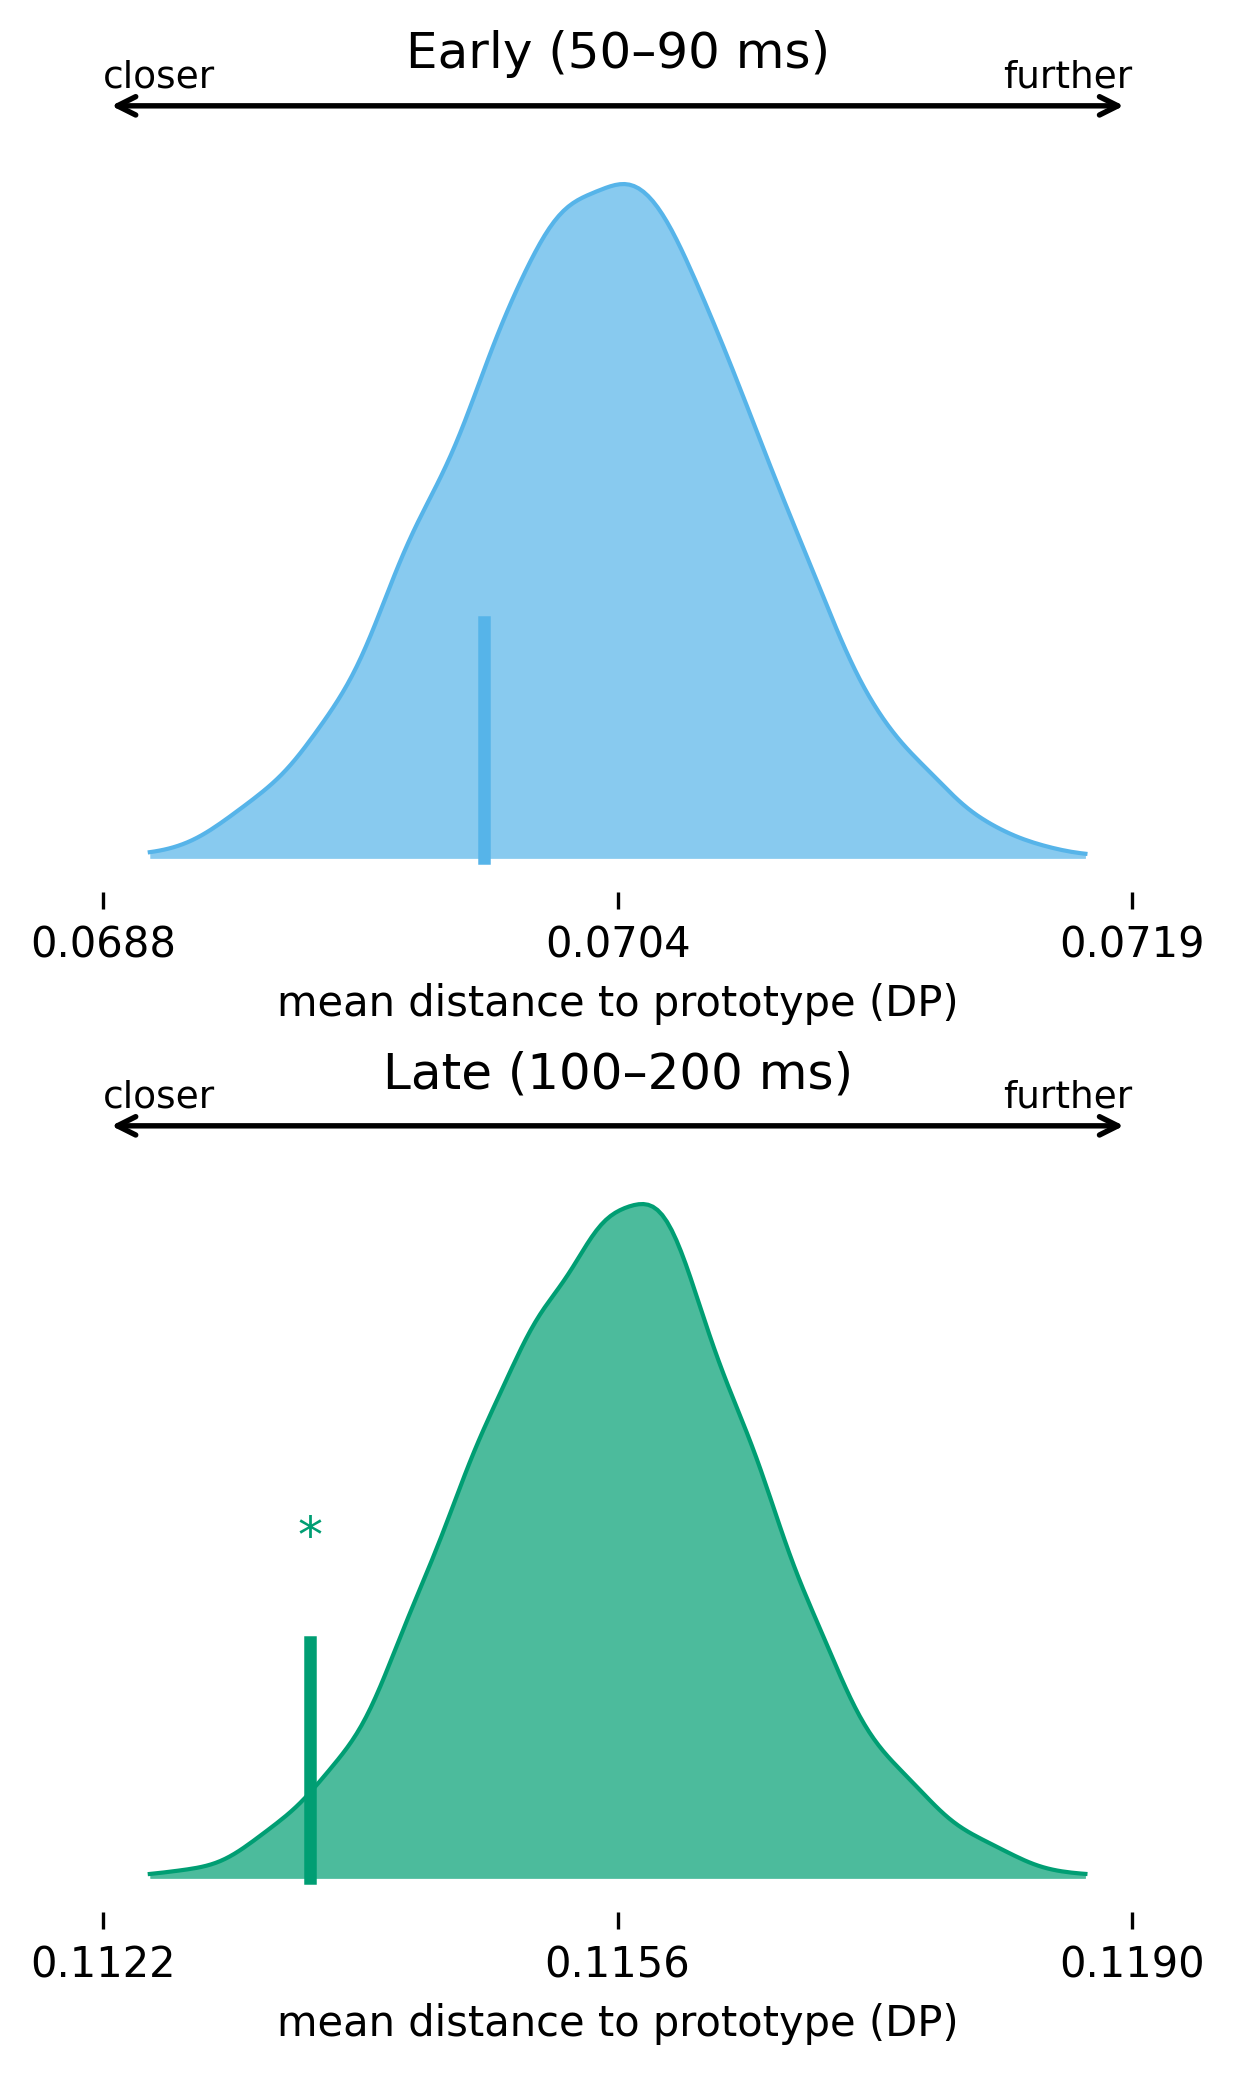

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# Early & Late Distance to Prototype (DP): two rotated-density subplots
# ─────────────────────────────────────────────────────────────────────────────
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from scipy.stats import gaussian_kde

import jax.numpy as jnp
from jax import jit
from statsmodels.stats.multitest import multipletests

# ------------------------------ Paths & Config ------------------------------
META_PATH = 'downloads/hvm_public_extended_meta.csv'
EVEN_PATH = 'downloads/Spike_count_even_sessions_ms_free.npy'
ODD_PATH  = 'downloads/Spike_count_odd_sessions_ms_free.npy'

FIG_DIR   = 'Figures'
N_PERM    = 10_000
RNG_SEED  = 42

# Color codes: early = blue, late = green
PALETTE_EARLY = {'Perm': '#56B4E9', 'Obs': '#56B4E9'}
PALETTE_LATE  = {'Perm': '#009E73', 'Obs': '#009E73'}

plt.rcParams.update({"svg.fonttype": "none"})  # keep text editable in SVG
os.makedirs(FIG_DIR, exist_ok=True)

# ------------------------------ Helpers -------------------------------------
@jit
def sqeucl(mat: jnp.ndarray, vec: jnp.ndarray) -> jnp.ndarray:
    """Row-wise mean-squared Euclidean distance to vec."""
    return jnp.mean((mat - vec) ** 2, axis=1)

def q_to_stars(q: float) -> str:
    if q < 1e-4: return '****'
    if q < 1e-3: return '***'
    if q < 1e-2: return '**'
    if q < 5e-2: return '*'
    return ''

def _set_three_ticks(ax):
    """Force exactly three evenly spaced xticks on current x-limits."""
    xmin, xmax = ax.get_xlim()
    ticks = np.linspace(xmin, xmax, 3)
    ax.set_xticks(ticks)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.4f'))

def plot_rotated_density_single(ax, title, obs, null_dist, q_val, xlabel, palette):
    """One rotated-density panel (with three xticks)."""
    # KDE grid on 0.1–99.9 % range (light truncation)
    p_lo, p_hi = np.percentile(null_dist, [0.1, 99.9])
    pad = 0.02 * (p_hi - p_lo)
    x_g = np.linspace(p_lo - pad, p_hi + pad, 200)
    dens = gaussian_kde(null_dist)(x_g)
    dens[dens < 0.005 * dens.max()] = 0
    max_d = dens.max() or 1e-8

    # density + observed line
    ax.fill_between(x_g, 0, dens, color=palette['Perm'], alpha=.7, lw=0)
    ax.plot(x_g, dens, color=palette['Perm'], lw=1)
    ln = 0.35 * max_d
    ax.plot([obs, obs], [0, ln], color=palette['Obs'], lw=3)

    # significance stars (use q-value)
    stars = q_to_stars(q_val)
    if stars:
        ax.text(obs, ln + 0.12 * max_d, stars, ha='center', va='bottom',
                fontsize=12, color=palette['Obs'])

    # cosmetics
    ax.set_yticks([])
    ax.tick_params(axis='y', left=False, labelleft=False)
    for s in ax.spines.values():
        s.set_visible(False)
    ax.set_xlabel(xlabel, fontsize=10)
    ax.tick_params(axis='x', bottom=True, labelbottom=True, length=4)
    ax.set_title(title, fontsize=12, pad=20)
    _set_three_ticks(ax)

    # horizontal “closer↔further” guide
    arrow_y = 1.06
    ax.annotate('', xy=(1, arrow_y), xytext=(0, arrow_y),
                xycoords='axes fraction', textcoords='axes fraction',
                arrowprops=dict(arrowstyle='<->', lw=1.3, color='black'),
                clip_on=False)
    ax.text(0, arrow_y + 0.015, 'closer', transform=ax.transAxes,
            ha='left', va='bottom', fontsize=9)
    ax.text(1, arrow_y + 0.015, 'further', transform=ax.transAxes,
            ha='right', va='bottom', fontsize=9)

def compute_dp_for_window(X_full: jnp.ndarray,
                          meta: pd.DataFrame,
                          rng: np.random.Generator):
    """
    Compute grand-mean Distance to Prototype (DP) and its null for a window.

    Processing:
      1) center features
      2) PCA to 50 dims (on all trials in the window)
      3) build object prototypes from LOW-variation exemplars in PCA space
      4) compute per-object mean DP for HIGH-variation images
      5) null by resampling category-matched HIGH-variation images (exclude same object)
    """
    # masks (accept both numeric and string encodings if present)
    var_col = meta['variation'].values
    low_var_mask  = (var_col == 0) | (var_col == 'background_only')
    high_var_mask = (var_col == 3) | (var_col == 'full_variation') | (var_col == 'full')

    # 1) center (as jnp)
    X_full = jnp.array(X_full)
    mean_vec = jnp.mean(X_full, axis=0)
    Xc = X_full - mean_vec

    # 2) PCA(50) with SVD
    _, _, Vt = jnp.linalg.svd(Xc, full_matrices=False)
    comps = Vt[:50]  # (50, D)
    Z = (X_full - mean_vec) @ comps.T  # (n_trials, 50)

    # numpy views for metadata
    obj_all = meta['object_name'].values
    cat_all = meta['category_name'].values

    dist_true  = []
    dist_nulls = []

    for obj in pd.unique(obj_all):
        lv_idx = np.where(low_var_mask & (obj_all == obj))[0]
        hv_idx = np.where(high_var_mask & (obj_all == obj))[0]
        if lv_idx.size == 0 or hv_idx.size == 0:
            continue

        # prototype in PCA space
        template = jnp.mean(Z[lv_idx], axis=0)

        # observed DPs for this object's HIGH-variation images
        dists = np.asarray(sqeucl(Z[hv_idx], template))
        dist_true.append(dists.mean())

        # category-matched HIGH-variation pool excluding this object
        cat = cat_all[lv_idx[0]]
        pool_mask = high_var_mask & (cat_all == cat) & (obj_all != obj)
        pool_idx = np.where(pool_mask)[0]
        if pool_idx.size == 0:
            continue
        pool_d = np.asarray(sqeucl(Z[pool_idx], template))

        # null: resample same count as hv_idx, take mean; repeat N_PERM
        perm_means = rng.choice(pool_d, size=(N_PERM, hv_idx.size), replace=True).mean(axis=1)
        dist_nulls.append(perm_means)

    dist_true  = np.array(dist_true)
    if len(dist_nulls) == 0:
        emp_dist  = np.nan
        null_dist = np.full(N_PERM, np.nan, dtype=float)
        p_dist    = np.nan
    else:
        dist_nulls = np.vstack(dist_nulls)         # (n_obj, N_PERM)
        emp_dist   = dist_true.mean() if dist_true.size else np.nan
        null_dist  = dist_nulls.mean(axis=0)       # (N_PERM,)
        p_dist     = (null_dist <= emp_dist).mean() if np.isfinite(emp_dist) else np.nan

    return float(emp_dist), np.asarray(null_dist, float), float(p_dist)

# ------------------------------ Data & Windows ------------------------------
print('Loading metadata …')
meta = pd.read_csv(META_PATH)

print('Loading neural data …')
rate = (np.load(EVEN_PATH) + np.load(ODD_PATH)) / 2.0  # trials × channels × timebins

# 10-ms bins edges (left edges): 0,10,...,190
time_edges = np.arange(0, 200, 10)

# Early window: 50–90 ms
early_bins = np.where((time_edges >= 50) & (time_edges <= 90))[0]

# Late window: 100–200 ms
late_bins  = np.where((time_edges >= 100) & (time_edges <= 200))[0]

# Flatten per window (channels × selected timebins)
X_early = rate[:, :, early_bins].reshape(rate.shape[0], -1).astype('float32')
X_late  = rate[:, :, late_bins ].reshape(rate.shape[0], -1).astype('float32')

# ------------------------------ DP for both windows -------------------------
rng = np.random.default_rng(RNG_SEED)

print('Computing DP (early 50–90 ms) …')
emp_e, null_e, p_e = compute_dp_for_window(X_early, meta, rng)
print(f"Early DP grand mean = {emp_e:.4f}, p = {p_e:.4g}")

print('Computing DP (late 100–200 ms) …')
emp_l, null_l, p_l = compute_dp_for_window(X_late,  meta, rng)
print(f"Late  DP grand mean = {emp_l:.4f}, p = {p_l:.4g}")

# ------------------------------ BH–FDR & Plot -------------------------------
# FDR across the two windows; use q-values to place stars
p_vec = np.array([p_e, p_l], dtype=float)
mask  = ~np.isnan(p_vec)
q_vec = np.full_like(p_vec, np.nan, dtype=float)
if mask.any():
    _, q_corr, _, _ = multipletests(p_vec[mask], method='fdr_bh')
    q_vec[mask] = q_corr
q_e, q_l = q_vec.tolist()

fig, axes = plt.subplots(2, 1, figsize=(4.0, 6.8), constrained_layout=True)
plot_rotated_density_single(
    axes[0], 'Early (50–90 ms)',
    emp_e, null_e, q_e,
    'mean distance to prototype (DP)', PALETTE_EARLY
)
plot_rotated_density_single(
    axes[1], 'Late (100–200 ms)',
    emp_l, null_l, q_l,
    'mean distance to prototype (DP)', PALETTE_LATE
)

for ext in ('png', 'svg', 'pdf'):
    fig.savefig(os.path.join(FIG_DIR, f'distance_to_prototype_early_late.{ext}'), dpi=300)
print(f"Figure saved to {FIG_DIR}/distance_to_prototype_early_late.(png|svg|pdf)")

# Contribution of category and position priors to object recognition

Loading metadata …
Loading neural data …
Running PCA (50 comps) …
Figure saved to Figures/gain_rotated_density_dp.(png|svg|pdf)
Saved q-values to Statistics/q_values_gain_dp.npz


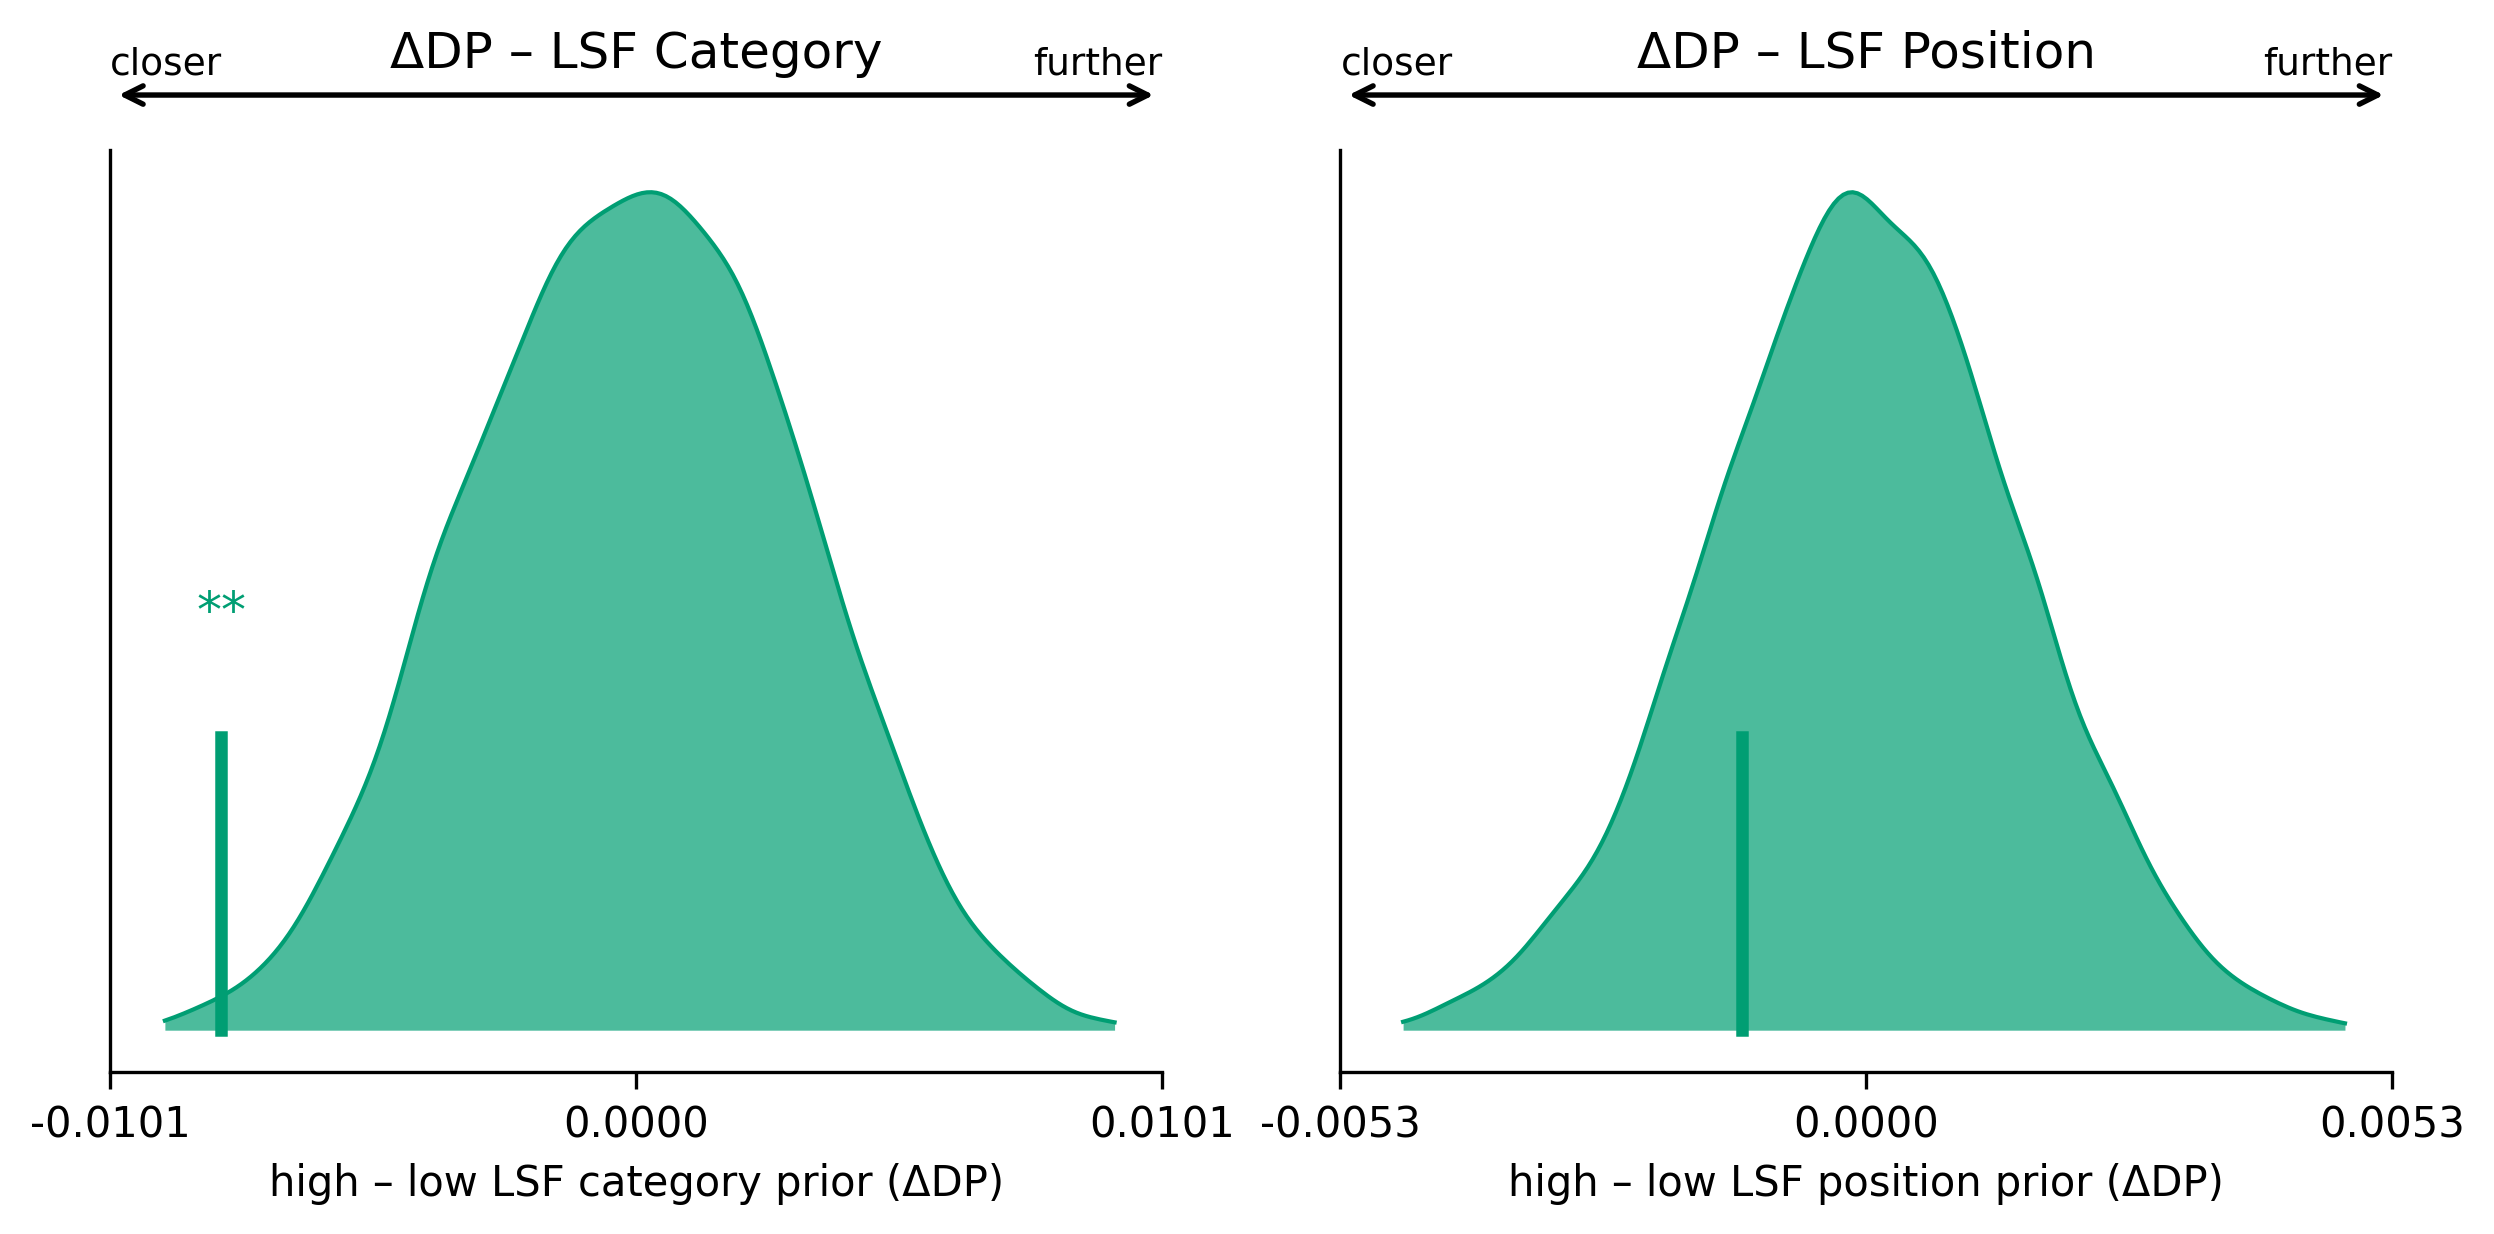

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# Δ Distance to Prototype (DP): LSF-category & LSF-position gains (late window)
# ─────────────────────────────────────────────────────────────────────────────
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from scipy.stats import gaussian_kde

import jax.numpy as jnp
from jax import jit

META_PATH      = 'downloads/hvm_public_extended_meta.csv'
EVEN_PATH      = 'downloads/Spike_count_even_sessions_ms_free.npy'
ODD_PATH       = 'downloads/Spike_count_odd_sessions_ms_free.npy'
CAT_PROB_PATH  = 'downloads/mean_predprob_per_trial_lowpass.npy'
POS_ERR_PATH   = 'downloads/mean_pos_error_per_trial.npy'

FIG_DIR        = 'Figures'
STAT_DIR       = 'Statistics'
N_PERM         = 10_000   # permutations / sign-flips
RNG_SEED       = 42

PALETTE = {'Perm': '#009E73', 'Obs': '#009E73'}
plt.rcParams.update({"svg.fonttype": "none"})  # editable text in SVG

# Create Statistics directory if it doesn't exist
os.makedirs(STAT_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

# Needed here (in case not imported above in the notebook)
import seaborn as sns
from statsmodels.stats.multitest import multipletests

# ───────────────────────────── helper functions ──────────────────────────────
@jit
def sqeucl(mat: jnp.ndarray, vec: jnp.ndarray) -> jnp.ndarray:
    """Row-wise mean-squared Euclidean distance to *vec*."""
    return jnp.mean((mat - vec) ** 2, axis=1)

def q_to_stars(q: float) -> str:
    if q < 1e-4: return '****'
    if q < 1e-3: return '***'
    if q < 1e-2: return '**'
    if q < 5e-2: return '*'
    return ''

def _set_three_ticks(ax):
    """Set symmetric x-limits and ticks at [-L, 0, +L] with 0 centered."""
    xmin, xmax = ax.get_xlim()
    L = float(max(abs(xmin), abs(xmax)))
    if not np.isfinite(L) or L == 0:
        L = 1.0
    ax.set_xlim(-L, L)
    ax.set_xticks([-L, 0.0, L])
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.4f'))

def plot_rotated_density_single(ax, title, obs, null_dist, q_val, xlabel):
    """One rotated-density panel (with three xticks)."""
    # KDE grid on 0.1–99.9 % range
    p_lo, p_hi = np.percentile(null_dist, [0.1, 99.9])
    pad = 0.02 * (p_hi - p_lo)
    x_g = np.linspace(p_lo - pad, p_hi + pad, 200)
    dens = gaussian_kde(null_dist)(x_g)
    dens[dens < 0.005 * dens.max()] = 0
    max_d = dens.max() or 1e-8

    # density + observed line
    ax.fill_between(x_g, 0, dens, color=PALETTE['Perm'], alpha=.7, lw=0)
    ax.plot(x_g, dens, color=PALETTE['Perm'], lw=1)
    ln = 0.35 * max_d
    ax.plot([obs, obs], [0, ln], color=PALETTE['Obs'], lw=3)

    # stars (use q-value)
    if (stars := q_to_stars(q_val)):
        ax.text(obs, ln + 0.12 * max_d, stars, ha='center', va='bottom',
                fontsize=12, color=PALETTE['Obs'])

    # cosmetics
    ax.set_yticks([])
    ax.tick_params(axis='y', left=False, labelleft=False)
    for s in ax.spines.values():
        s.set_visible(False)
    ax.set_xlabel(xlabel, fontsize=10)
    ax.tick_params(axis='x', bottom=True, labelbottom=True, length=4)
    ax.set_title(title, fontsize=12, pad=20)

    # enforce three ticks after limits settle
    _set_three_ticks(ax)

    # arrow
    arrow_y = 1.06
    ax.annotate('', xy=(1, arrow_y), xytext=(0, arrow_y),
                xycoords='axes fraction', textcoords='axes fraction',
                arrowprops=dict(arrowstyle='<->', lw=1.3, color='black'),
                clip_on=False)
    ax.text(0, arrow_y + 0.015, 'closer', transform=ax.transAxes,
            ha='left', va='bottom', fontsize=9)
    ax.text(1, arrow_y + 0.015, 'further', transform=ax.transAxes,
            ha='right', va='bottom', fontsize=9)

# --- metadata
print('Loading metadata …')
meta = pd.read_csv(META_PATH)
low_var  = (meta.variation == 0) | (meta.variation == 'background_only')
high_var = (meta.variation == 3) | (meta.variation == 'full_variation') | (meta.variation == 'full')
high_idx = np.nonzero(high_var.values)[0]
g2h = -np.ones(len(meta), int); g2h[high_idx] = np.arange(high_idx.size)

# --- neural data (100–200 ms)
print('Loading neural data …')
rate = (np.load(EVEN_PATH) + np.load(ODD_PATH)) / 2.0
t_bins = np.arange(0, 200, 10)
late_mask = (t_bins >= 100) & (t_bins <= 200)
X = rate[:, :, late_mask].reshape(rate.shape[0], -1).astype('float32')
X = jnp.array(X)

# --- PCA (50 components)
print('Running PCA (50 comps) …')
X_mean = X.mean(axis=0)
Xc = X - X_mean
_, _, Vt = jnp.linalg.svd(Xc, full_matrices=False)
comps = Vt[:50]  # 50 principal axes

# project data
proj_all  = (X - X_mean) @ comps.T
proj_high = proj_all[high_idx]

hv_obj = meta.object_name.values[high_idx]
hv_cat = meta.category_name.values[high_idx]

cat_prob = np.load(CAT_PROB_PATH)
pos_err  = np.load(POS_ERR_PATH)

rng = np.random.default_rng(RNG_SEED)

# Collect per-object ΔDP components
gain_cat, gain_pos = [], []

for obj in meta.object_name.unique():
    lv_idx = meta[(meta.object_name == obj) & low_var].index.values
    hv_idx = meta[(meta.object_name == obj) & high_var].index.values
    if lv_idx.size == 0 or hv_idx.size == 0:
        continue

    # prototype from LOW-variation in PCA space
    template = proj_all[lv_idx].mean(axis=0)

    # distances for this object’s HIGH-variation images (in PCA space)
    hv_hi = g2h[hv_idx]
    dists = np.asarray(sqeucl(proj_high[hv_hi], template))  # per-image DP

    # LSF gains (category prior and position prior)
    cp = cat_prob[hv_hi]
    pe = pos_err[hv_hi]

    mask_exp = cp > np.median(cp);  mask_un  = ~mask_exp
    mask_loc = pe < np.median(pe);  mask_mis = ~mask_loc

    if mask_exp.any() and mask_un.any():
        gain_cat.append(dists[mask_exp].mean() - dists[mask_un].mean())
    if mask_loc.any() and mask_mis.any():
        gain_pos.append(dists[mask_loc].mean() - dists[mask_mis].mean())

# --- stats (sign-flip nulls for the two ΔDP panels)
emp_cat = float(np.mean(gain_cat)) if len(gain_cat) else np.nan
emp_pos = float(np.mean(gain_pos)) if len(gain_pos) else np.nan

signs_cat = rng.choice([-1, 1], size=(N_PERM, len(gain_cat))) if len(gain_cat) else np.empty((0,0))
signs_pos = rng.choice([-1, 1], size=(N_PERM, len(gain_pos))) if len(gain_pos) else np.empty((0,0))

null_cat = (np.array(gain_cat)[None, :] * signs_cat).mean(axis=1) if len(gain_cat) else np.array([np.nan])
null_pos = (np.array(gain_pos)[None, :] * signs_pos).mean(axis=1) if len(gain_pos) else np.array([np.nan])

# one-sided p-values
p_cat = float((null_cat <= emp_cat).mean()) if len(gain_cat) else np.nan
p_pos = float((null_pos <= emp_pos).mean()) if len(gain_pos) else np.nan

# --- BH–FDR (use q-values on the figures)
p_vec = np.array([p_cat, p_pos], dtype=float)
mask  = ~np.isnan(p_vec)
q_vec = np.full_like(p_vec, np.nan, dtype=float)
if mask.any():
    _, q_corr, _, _ = multipletests(p_vec[mask], method='fdr_bh')
    q_vec[mask] = q_corr
q_cat, q_pos = q_vec.tolist()

# Save both raw p and FDR-corrected q values
np.save(os.path.join(STAT_DIR, 'p_value_gain_cat.npy'), p_cat)
np.save(os.path.join(STAT_DIR, 'p_value_gain_pos.npy'), p_pos)
np.savez(os.path.join(STAT_DIR, 'q_values_gain_dp.npz'), q_cat=q_cat, q_pos=q_pos)

# --- plotting (ONLY the two ΔDP panels; pass q-values to star-logic)
fig, axes = plt.subplots(1, 2, figsize=(8.2, 4), constrained_layout=True)

plot_rotated_density_single(
    axes[0], 'ΔDP – LSF Category',
    emp_cat, null_cat, q_cat,
    'high – low LSF category prior (ΔDP)'
)
plot_rotated_density_single(
    axes[1], 'ΔDP – LSF Position',
    emp_pos, null_pos, q_pos,
    'high – low LSF position prior (ΔDP)'
)

sns.despine()
for ext in ('png', 'svg', 'pdf'):
    fig.savefig(os.path.join(FIG_DIR, f'gain_rotated_density_dp.{ext}'), dpi=300)
print(f'Figure saved to {FIG_DIR}/gain_rotated_density_dp.(png|svg|pdf)')
print(f"Saved q-values to {STAT_DIR}/q_values_gain_dp.npz")

# Richness of representations

## Analysis

In [ ]:
import warnings
from pathlib import Path
from collections import defaultdict
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import rankdata
from statsmodels.stats.multitest import multipletests
from sklearn.manifold import MDS
from scipy.spatial.distance import pdist, squareform
from matplotlib import colors as mcolors
from PIL import Image
import cv2
import time
import re
import pickle
from joblib import Parallel, delayed
from tqdm import tqdm
import os
import sys
import glob

from utils.extract_and_download_data import download_files, unzip
from utils.analysis_utils import (spearman_corr_ranked, rank_data, robust_rdm, rank_data_batch)
from utils.plotting_utils import q_to_stars

# -------------------------------------------------------------------
# Analysis Script
# -------------------------------------------------------------------

print("Analysis Script start")

# Global parameters
N_PERM        = 10000
PERM_CHUNK    = 2000
N_BATCH_RANK  = 500
RNG = np.random.default_rng(42)

FIGURES_DIR   = Path("Figures")
STATISTICS_DIR = Path("Statistics")
DATA_FNAME    = STATISTICS_DIR / "rsa_results.npz"
# -------------------------------------------------------------------
# Load spike counts & metadata
print("Loading spike counts & metadata …")
spike_counts_even = np.load("downloads/Spike_count_even_sessions_ms_free.npy",
                            allow_pickle=True)
spike_counts_odd  = np.load("downloads/Spike_count_odd_sessions_ms_free.npy",
                            allow_pickle=True)
spike_counts = (spike_counts_even + spike_counts_odd) / 2.0
meta         = pd.read_csv("downloads/hvm_public_extended_meta.csv")

EARLY_SLICE = slice(5, 9)    # 50–90 ms
LATE_SLICE  = slice(10, 20)  # 100–200 ms
slices = [EARLY_SLICE, LATE_SLICE]

hv_idx    = np.where(meta["rxz"] != 0)[0]
cat_codes = meta["category_name"].astype("category").cat.codes.to_numpy()
obs_hv, perm_hv = np.zeros(2), np.zeros((N_PERM, 2))

print("Face feature models …")
face_idx = np.where((meta["rxz"] != 0) &
                    (meta["category_name"] == "Faces"))[0]
faces    = meta.loc[face_idx]

orient    = faces[["rxy_semantic","rxz_semantic","ryz_semantic"]].to_numpy(float)
size_feat = faces["s"].to_numpy(float)[:, None]
pos       = faces[["centroid_y","centroid_x"]].to_numpy(float)
pos       = (pos - 128.0) / 256.0 * 8.0
ang       = np.arctan2(pos[:,1], pos[:,0])
pos_vec   = np.c_[np.cos(ang), np.sin(ang)]

obs_face  = {k: np.zeros(2)       for k in ["orient","size","pos"]}
perm_face = {k: np.zeros((N_PERM,2)) for k in ["orient","size","pos"]}

for key, feat in [("orient", orient), ("size", size_feat), ("pos", pos_vec)]:
    for w, sl in enumerate(slices):
        neu   = spike_counts[face_idx, :, sl].reshape(len(face_idx), -1)
        r_neu = rank_data(pdist(neu, "euclidean"))
        dist  = "cosine" if key == "orient" else "euclidean"
        r_feat = rank_data(pdist(feat, dist)) if key == "orient" else \
                 rank_data(pdist(feat, dist))
        obs_face[key][w] = spearman_corr_ranked(r_neu, r_feat)

        Xc, dc = r_neu - r_neu.mean(), np.linalg.norm(r_neu - r_neu.mean())
        for p_start in range(0, N_PERM, PERM_CHUNK):
            p_end = min(p_start + PERM_CHUNK, N_PERM)
            sz    = p_end - p_start
            perms = np.stack([
                rank_data(pdist(feat[RNG.permutation(len(feat))], dist))
                for _ in range(sz)
            ], axis=1)
            Y = perms - perms.mean(0)
            perm_face[key][p_start:p_end, w] += (Xc[:, None] * Y).sum(0) / dc / \
                                               np.sqrt((Y**2).sum(0))

print("In-paint RSA …")
unzip("downloads/deepNetFeatures_landscape.zip",
      "downloads/deepNetFeatures_landscape")

def load_all(mode):
    paths = sorted(
        glob.glob(f"downloads/deepNetFeatures_landscape/*CLIP*features_{mode}.pkl"))
    feats, names = [], []
    for pkl in paths:
        with open(pkl, "rb") as f:
            d = pickle.load(f)
        feats.append(d["penultimate"].reshape(d["penultimate"].shape[0], -1))
        names.append(pd.Index(d["image_names"]))
    common = names[0]
    for nm in names[1:]:
        common = common.intersection(nm)
    common = common.sort_values()
    idxs   = [nm.get_indexer(common) for nm in names]
    return common, [f[i] for f, i in zip(feats, idxs)]

common, feats_list = load_all("inpainted_images_original")
idx_c      = pd.Index(meta["image_id"].str.strip()).get_indexer(common)
sc_inpaint = spike_counts[idx_c]
meta_in    = meta.set_index("image_id").loc[common].reset_index()

results = {}
for key, sl in zip(["Early","Late"], slices):
    neural = sc_inpaint[:, :, sl].reshape(sc_inpaint.shape[0], -1)
    obs, perm = [], []
    for obj in meta_in["object_name"].unique():
        idx_o = np.where(meta_in["object_name"] == obj)[0]
        if len(idx_o) < 3:
            continue
        r_neu = rank_data(pdist(neural[idx_o], "euclidean"))
        r_inp = robust_rdm([f[idx_o] for f in feats_list])
        obs.append(spearman_corr_ranked(r_neu, r_inp))

        Xc, dc = r_neu - r_neu.mean(), np.linalg.norm(r_neu - r_neu.mean())
        perm_vals = np.zeros((len(r_neu), N_PERM))
        for p_start in range(0, N_PERM, PERM_CHUNK):
            p_end = min(p_start + PERM_CHUNK, N_PERM)
            for j in range(p_start, p_end):
                perm_idx = RNG.permutation(len(idx_o))
                perm_vals[:, j] = rank_data(
                    pdist(neural[idx_o][perm_idx], "euclidean"))
        perm_ranked = rank_data_batch(perm_vals, N_BATCH_RANK)
        perm.append([spearman_corr_ranked(perm_ranked[:, j], r_inp)
                     for j in range(N_PERM)])
    results[key] = {"obs": np.mean(obs),
                    "null": np.mean(np.vstack(perm), axis=0)}

# -------------------------------------------------------------------
# Save everything
STATISTICS_DIR.mkdir(exist_ok=True)
np.savez_compressed(
    DATA_FNAME,
    face_orient_obs=obs_face['orient'],
    face_orient_perm=perm_face['orient'],
    face_size_obs=obs_face['size'], face_size_perm=perm_face['size'],
    face_pos_obs=obs_face['pos'],  face_pos_perm=perm_face['pos'],
    inpaint_obs=np.array([results['Early']['obs'],
                          results['Late']['obs']]),
    inpaint_perm=np.column_stack([results['Early']['null'],
                                  results['Late']['null']])
)
print("Analysis complete – results saved.")


Analysis Script start
Loading spike counts & metadata …
Face feature models …
In-paint RSA …


/tmp/ipython-input-1987781888.py:109: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  d = pickle.load(f)


Analysis complete – results saved.


## Plot results

Plotting Script start
saved → Figures/all_rsa_panels_rotated_shared_x.svg


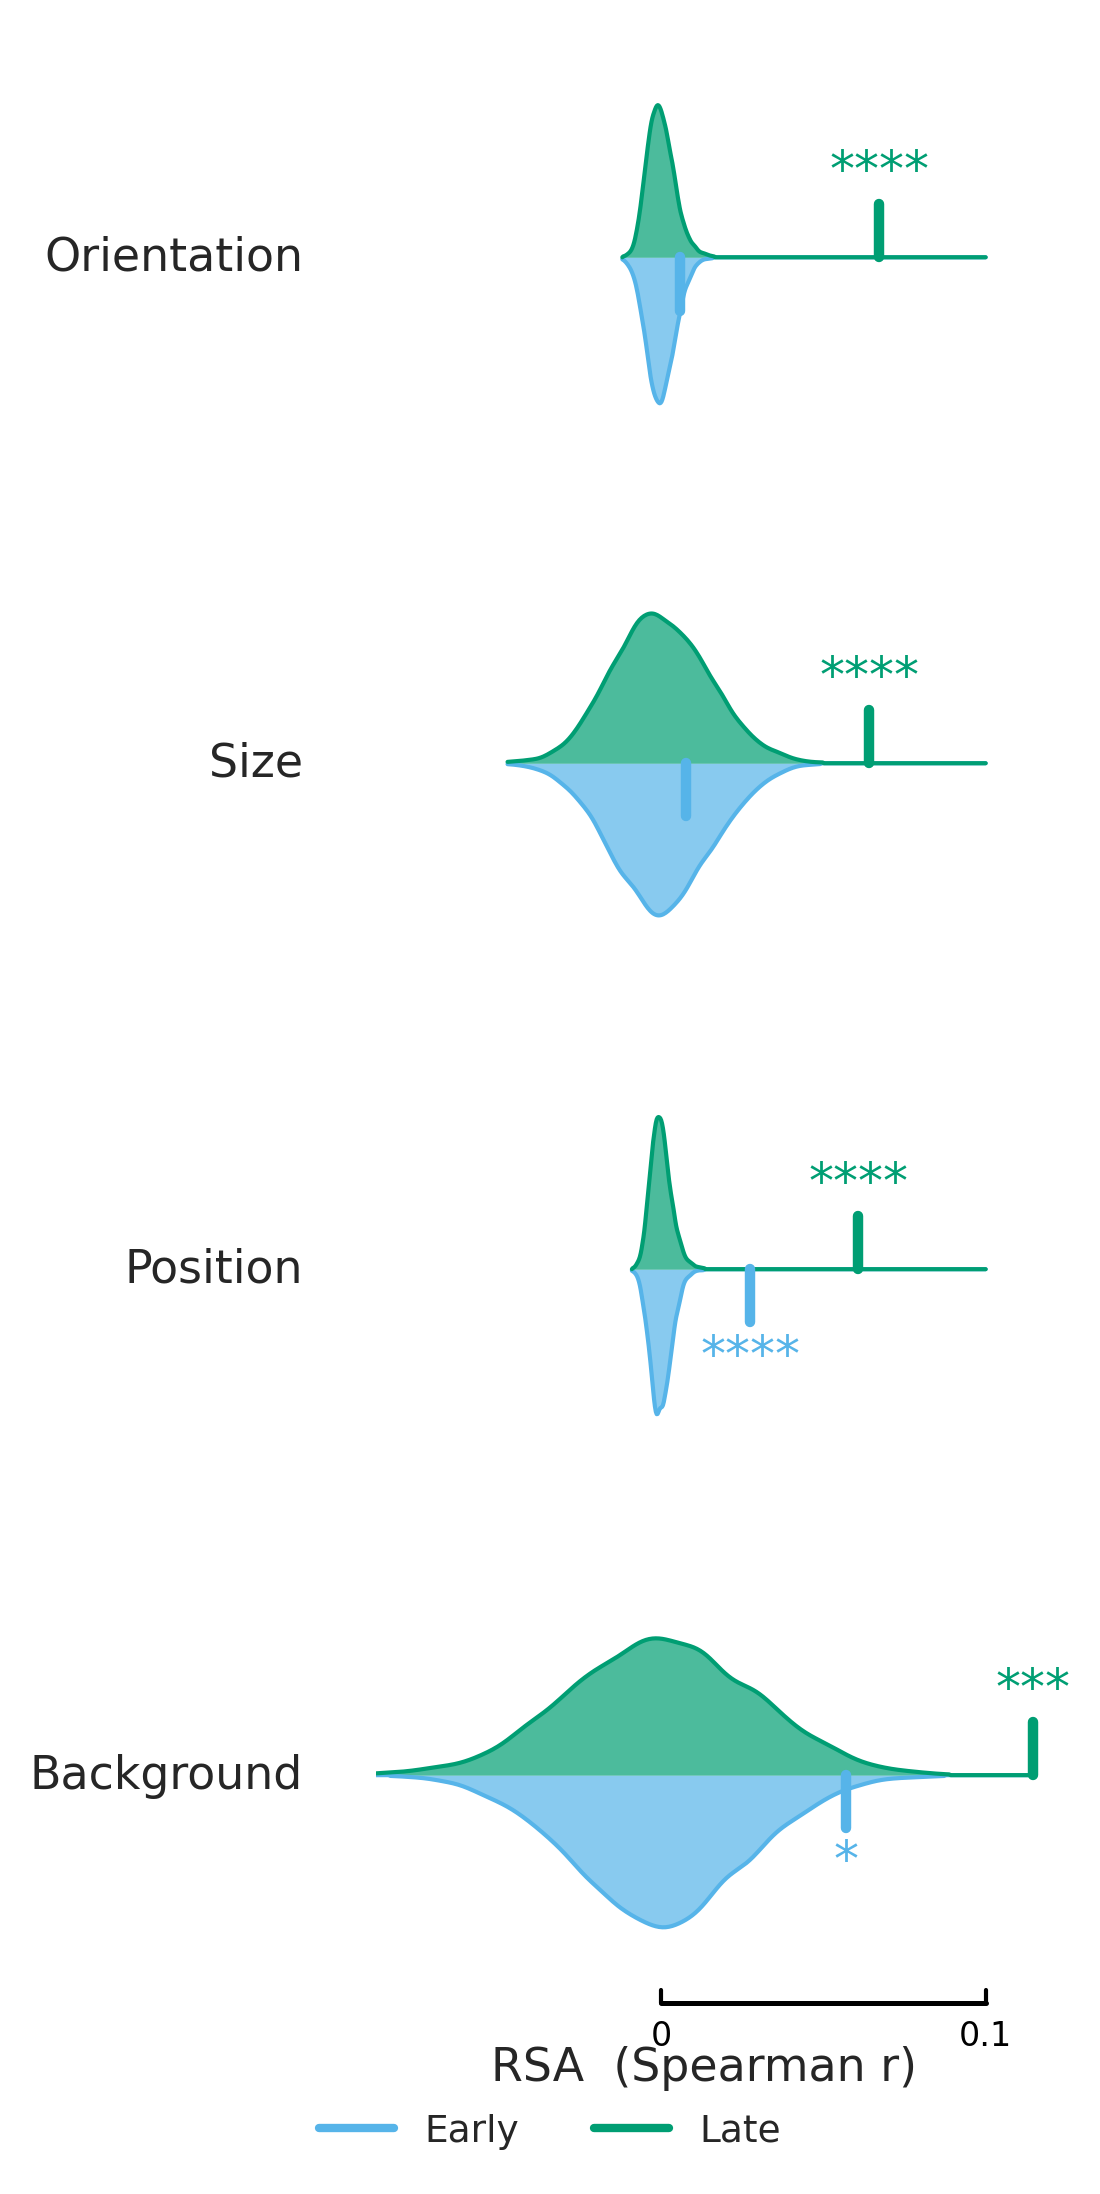

In [ ]:
# -------------------------------------------------------------------
# Plotting Script
# -------------------------------------------------------------------

print("Plotting Script start")

from scipy.stats import gaussian_kde
from statsmodels.stats.multitest import fdrcorrection
from matplotlib.lines import Line2D


PALETTE = {                            # Okabe–Ito, safe for red-green color blind
    "Early":   "#56B4E9",
    "Late": "#009E73"
}
WANT = [
    ("Orientation", "face_orient_obs", "face_orient_perm"),
    ("Size",        "face_size_obs",   "face_size_perm"),
    ("Position",    "face_pos_obs",    "face_pos_perm"),
    ("Background",  "inpaint_obs",     "inpaint_perm"),
]
sns.set_style("white")

def q_to_stars(q):
    return "****" if q < 1e-4 else "***" if q < 1e-3 else "**" if q < 1e-2 else "*" if q < .05 else ""

# ───────── helper to draw ONE panel ─────────
def plot_rotated_density_panel(ax, title_text, obs_rsa, perm_rsa,
                               p_fdr_early, p_fdr_late, is_last):
    """Rotated violin-style density: negative y = Early, positive y = Late."""
    perm_early, perm_late = perm_rsa[:, 0], perm_rsa[:, 1]

    # KDE grid restricted to dense region **AND** forced to include observed values & baseline end-points
    comb = np.concatenate([perm_early, perm_late])
    lo, hi = np.percentile(comb, [.1, 99.9])
    pad = (hi - lo) * 0.02
    xmin = min(lo - pad, obs_rsa.min(), 0)          # include 0 for baseline
    xmax = max(hi + pad, obs_rsa.max(), 0.10)       # include 0.10 for baseline
    x_grid = np.linspace(xmin, xmax, 400)

    dens_e = gaussian_kde(perm_early)(x_grid)
    dens_l = gaussian_kde(perm_late )(x_grid)

    # zero tiny tails
    dens_e[dens_e < 0.005 * dens_e.max()] = 0
    dens_l[dens_l < 0.005 * dens_l.max()] = 0
    max_d = max(dens_e.max(), dens_l.max(), 1e-8)

    # -- densities
    ax.fill_between(x_grid, -dens_e, 0,  color=PALETTE["Early"], alpha=0.7, lw=0)
    ax.plot(x_grid, -dens_e,              color=PALETTE["Early"], lw=1)
    ax.fill_between(x_grid, 0,  dens_l,   color=PALETTE["Late"],  alpha=0.7, lw=0)
    ax.plot(x_grid,  dens_l,              color=PALETTE["Late"],  lw=1)

    # observed vertical bars (never clipped now)
    bar_len = 0.35 * max_d
    ax.plot([obs_rsa[0]]*2, [0, -bar_len], color=PALETTE["Early"], lw=2.5, zorder=3, clip_on=False)
    ax.plot([obs_rsa[1]]*2, [0,  bar_len], color=PALETTE["Late"],  lw=2.5, zorder=3, clip_on=False)
    # significance stars
    star_pad = 0.06 * max_d             # 6 % of full density height

    # Plot star for Early
    s_early = q_to_stars(p_fdr_early)
    if s_early:
        y_bar_end_early = -bar_len
        y_star_early    = y_bar_end_early - star_pad
        ax.text(obs_rsa[0], y_star_early, s_early, ha='center',
                va='top', fontsize=12, color=PALETTE["Early"], zorder=5)

    # Plot star for Late
    s_late = q_to_stars(p_fdr_late)
    if s_late:
        y_bar_end_late = bar_len
        y_star_late    = y_bar_end_late + star_pad
        ax.text(obs_rsa[1], y_star_late, s_late, ha='center',
                va='bottom', fontsize=12, color=PALETTE["Late"], zorder=5)


    # panel label on the left
    ax.set_ylabel(title_text, fontsize=11, rotation=0,
                  ha='right', va='center')
    ax.yaxis.set_label_coords(-0.11, 0.5)

    # tidy appearance
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(-max_d*1.5, max_d*1.5)
    ax.set_xticks([]); ax.set_yticks([])
    for s in ax.spines.values(): s.set_visible(False)

    # baseline + custom ticks ONLY on last subplot
    if is_last:
        y0 = ax.get_ylim()[0]
        tick_len = 0.25 * bar_len
        ax.plot([0, 0.10], [y0, y0], color='black', lw=1.2, clip_on=False, zorder=10)
        for xt in [0, 0.10]:
            ax.plot([xt, xt], [y0, y0 + tick_len], color='black', lw=1, clip_on=False, zorder=10)
            ax.text(xt, y0 - tick_len*1.2, f"{xt:0.2g}", ha='center', va='top',
                    fontsize=8, color='black', zorder=10)

        ax.set_xlabel("RSA  (Spearman r)", labelpad=10)
# ------------------------------------------------------------------


# ───────── load & prepare data ─────────
DATA_FNAME = os.path.join("Statistics", "rsa_results.npz")
dat = np.load(DATA_FNAME, allow_pickle=True)

valid = []
for title, ok, pk in WANT:
    if ok in dat and pk in dat:
        obs, perm = dat[ok], dat[pk]
        if obs.shape == (2,) and perm.ndim == 2 and perm.shape[1] == 2:
            valid.append((title, obs, perm))

if not valid:
    raise RuntimeError("No valid RSA metrics in file.")

# raw p-values then FDR
raw_ps_early = [(perm[:,0] >= obs[0]).mean() for _,obs,perm in valid]
raw_ps_late  = [(perm[:,1] >= obs[1]).mean() for _,obs,perm in valid]

_, qvals_early = fdrcorrection(raw_ps_early, alpha=0.05, method='indep')
_, qvals_late  = fdrcorrection(raw_ps_late, alpha=0.05, method='indep')

# ───────── figure ─────────
fig_h = max(2.5, 1.8 * len(valid))
fig, axes = plt.subplots(len(valid), 1, figsize=(3.8, fig_h),
                         tight_layout=True, sharex=True)
if len(valid) == 1:
    axes = [axes]

for i, (ax, (title, obs, perm)) in enumerate(zip(axes, valid)):
    plot_rotated_density_panel(ax, title, obs, perm,
                               p_fdr_early=qvals_early[i],
                               p_fdr_late=qvals_late[i],
                               is_last=(i == len(axes)-1))

# global legend (below all panels, outside plot)
legend_elems = [Line2D([0],[0], color=PALETTE['Early'], lw=2, label='Early'),
                Line2D([0],[0], color=PALETTE['Late'],  lw=2, label='Late')]
fig.legend(handles=legend_elems,
           loc='lower center', bbox_to_anchor=(0.5, -0.02),
           ncol=2, frameon=False, fontsize=9)

# save
os.makedirs("Figures", exist_ok=True)
out_path = Path("Figures") / "all_rsa_panels_rotated_shared_x.svg"
fig.savefig(out_path, dpi=300, bbox_inches='tight')
print(f"saved → {out_path}")

# Download figures and statistics

In [ ]:
import os
from google.colab import files

# Define the directories to zip
directories_to_zip = ["Figures", "Statistics"]
zip_filename = "results_eye_movement_control.zip"

# Check if directories exist before zipping
existing_directories = [d for d in directories_to_zip if os.path.exists(d)]

if existing_directories:
    # Create a zip archive of the specified directories
    zip_command = f"zip -r {zip_filename} {' '.join(existing_directories)}"
    os.system(zip_command)

    # Provide a download link for the zip file
    if os.path.exists(zip_filename):
        print(f"Created {zip_filename}")
        files.download(zip_filename)
    else:
        print(f"Failed to create {zip_filename}.")
else:
    print("Neither the 'Figures' nor the 'Statistics' directory was found.")

Created results_eye_movement_control.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>